# HydroSOS - Persistence and Hydrological Analogues method

In this notebook, we explore the Persistance and Hydrological Analogue method

## Import the python libraries

In [1]:
%reset -f

In [2]:
# Importing the libraries
import pandas as pd
import seaborn as sns
import numpy as np
import calendar
import datetime
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

from IPython.display import HTML

sns.set()

In [3]:
# install a conda package in the current Jupyter kernel
#import sys
#!conda install --yes --prefix {sys.prefix} missingno

In [4]:
import missingno

### We create function for percentile definition

In [5]:
# Quantile Function Definitions
def q1(x):
    return x.quantile(0.28)

def q2(x):
    return x.median()

def q3(x):
    return x.quantile(0.72)

def q5(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

def q87(x):
    return x.quantile(0.87)

def q13(x):
    return x.quantile(0.13)


## Import Data 

In this example we import the daily discharge data from Fray Marcos station, from 01 Jan 1980 to 31 Jan 2023. We import and then visualize head and tail of dataframe, plot timeseries and also make boxplot for daily discharge grouped by month.

In [6]:
DISCHARGE_DAILY = pd.read_csv('../data/fraymarcos_caudales.csv',parse_dates=['Fecha'],index_col="Fecha",dayfirst=True,na_values="NA")
# Identify the missing data
DISCHARGE_DAILY_date_missing = pd.date_range(start = '1980-01-01', end = '2023-01-31',freq='D')
DISCHARGE_DAILY = DISCHARGE_DAILY.reindex(DISCHARGE_DAILY_date_missing,fill_value=None)
DISCHARGE_DAILY.index.name = 'Fecha' # Set index Fecha
DISCHARGE_DAILY.columns = ['Station','Discharge']
DISCHARGE_DAILY = DISCHARGE_DAILY.drop(columns='Station')
HTML(DISCHARGE_DAILY.head(6).to_html())

,Discharge
Fecha,
1980-01-01,7.906
1980-01-02,7.978
1980-01-03,7.978
1980-01-04,7.978
1980-01-05,7.978
1980-01-06,7.978


In [7]:
HTML(DISCHARGE_DAILY.tail(6).to_html())

,Discharge
Fecha,
2023-01-26,0.681
2023-01-27,0.681
2023-01-28,0.685
2023-01-29,0.666
2023-01-30,0.666
2023-01-31,0.658


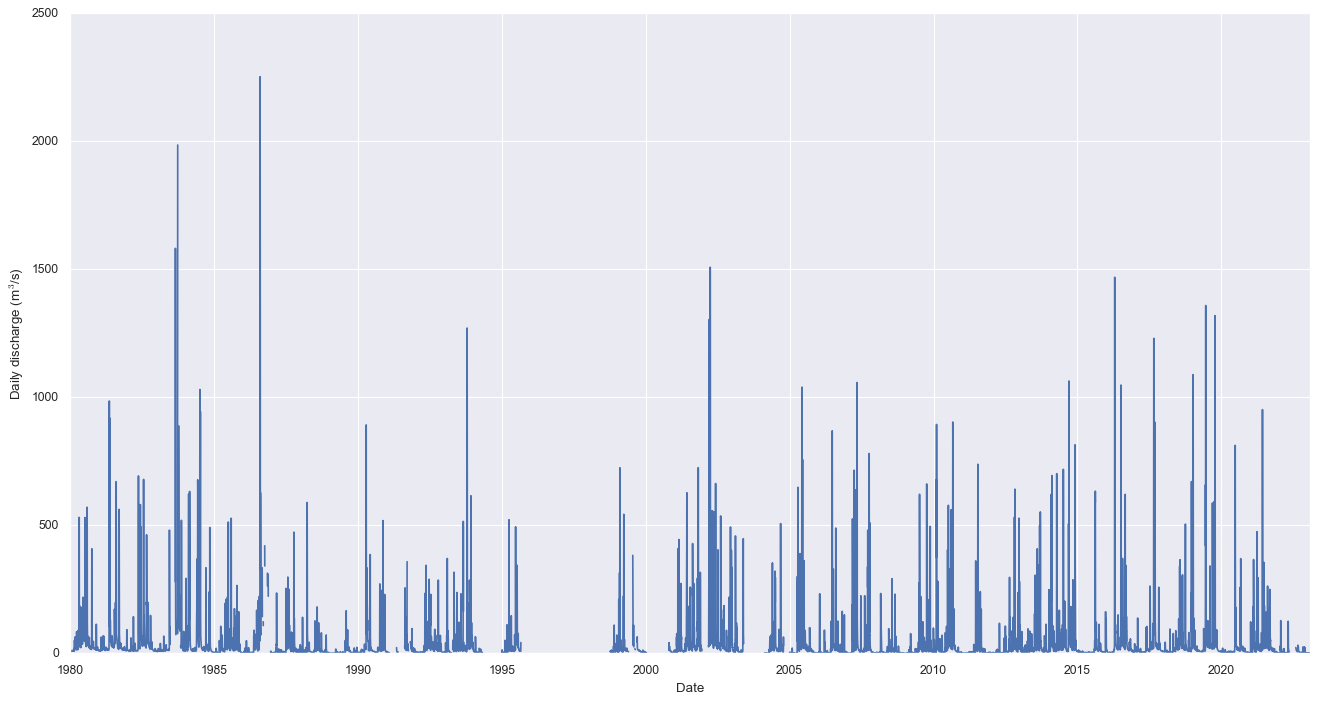

In [8]:
ax1 = DISCHARGE_DAILY['Discharge'].plot(figsize=(20, 10));
ax1.set_xlabel('Date');
ax1.set_ylabel('Daily discharge (m$^3$/s)');

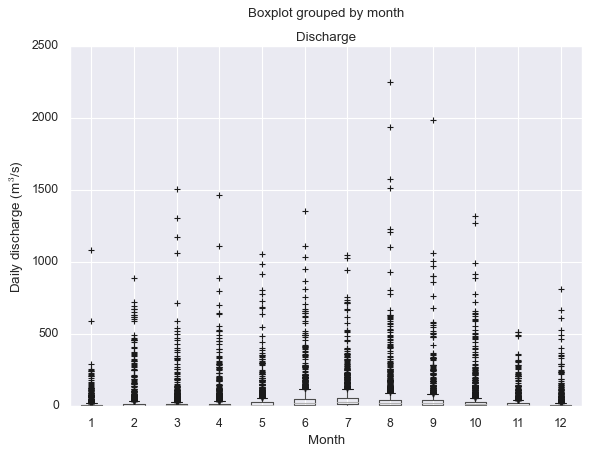

In [9]:
ax1 = DISCHARGE_DAILY.assign(month=DISCHARGE_DAILY.index.month).boxplot(column='Discharge',by='month')
ax1.set_xlabel('Month');
ax1.set_ylabel('Daily discharge (m$^3$/s)');

In [10]:
# Some diferent visualization for plot
# fig, ax = plt.subplots(figsize=(12, 6))
# sns.boxplot(
#     x='month', y='Discharge',
#     data=DISCHARGE_DAILY.assign(month=DISCHARGE_DAILY.index.month_name()),
#     ax=ax)

## Calculate monthly mean from daily data

First, we identify the months which contains lower that 5 null value observation.

In [11]:
# group the Dataframe in a monthly time scale
GROUPER_DISCHARGE_MONTHLY = DISCHARGE_DAILY.groupby(pd.Grouper(freq='1MS'))
NUMBER_MISSING = GROUPER_DISCHARGE_MONTHLY.apply(lambda x: pd.isnull(x).sum()).unstack(1)
# sum the number of null values and assing a "true" if the number of null values are lower that a number for a given month
BOOL_MISSING = GROUPER_DISCHARGE_MONTHLY.apply(lambda x: pd.isnull(x).sum()).unstack(1) < 5
BOOL_MISSING = BOOL_MISSING.to_frame() # convert to DataFrame
BOOL_MISSING.columns = ['missing'] # change the column name to "missing"

NUMBER_MISSING = NUMBER_MISSING.to_frame()
NUMBER_MISSING.columns = ['number_missing'] # change the column name to "missing"

In [12]:
NUMBER_MISSING

number_missing
          Fecha                     
Discharge 1980-01-01               0
          1980-02-01               0
          1980-03-01               0
          1980-04-01               0
          1980-05-01               0
...                              ...
          2022-09-01               0
          2022-10-01               0
          2022-11-01               0
          2022-12-01               2
          2023-01-01               1

[517 rows x 1 columns]

After this, we calculate the monthly mean flow only if the null values in that month are below 5 values. Also define de water year starting in april.

In [13]:
DISCHARGE_MONTHLY = DISCHARGE_DAILY.resample('M').apply(lambda x: x.mean() if x.isnull().sum() < 5 else np.nan)
DISCHARGE_MONTHLY['Year'] = DISCHARGE_MONTHLY.index.year
DISCHARGE_MONTHLY['Month'] = DISCHARGE_MONTHLY.index.month
DISCHARGE_MONTHLY['water_year'] = DISCHARGE_MONTHLY.index.year.where(DISCHARGE_MONTHLY.index.month < 4, DISCHARGE_MONTHLY.index.year + 1)

## create column for day, month, year in the daily discharge ()
DISCHARGE_DAILY['Year'] = DISCHARGE_DAILY.index.year
DISCHARGE_DAILY['Month'] = DISCHARGE_DAILY.index.month
DISCHARGE_DAILY['Day'] = DISCHARGE_DAILY.index.day
DISCHARGE_DAILY['monthday'] = DISCHARGE_DAILY.index.day_of_year
DISCHARGE_DAILY['water_year'] = DISCHARGE_DAILY.index.year.where(DISCHARGE_DAILY.index.month < 4, DISCHARGE_DAILY.index.year + 1)
## 
HTML(DISCHARGE_MONTHLY.head(18).to_html(index=False))
# DISCHARGE_MONTHLY.to_clipboard()

Discharge,Year,Month,water_year
8.646161,1980,1,1980
14.756828,1980,2,1980
30.993548,1980,3,1980
68.594033,1980,4,1981
53.190742,1980,5,1981
88.343367,1980,6,1981
80.379290,1980,7,1981
70.239710,1980,8,1981
21.893533,1980,9,1981
51.652935,1980,10,1981


Plot the monthly series discharge

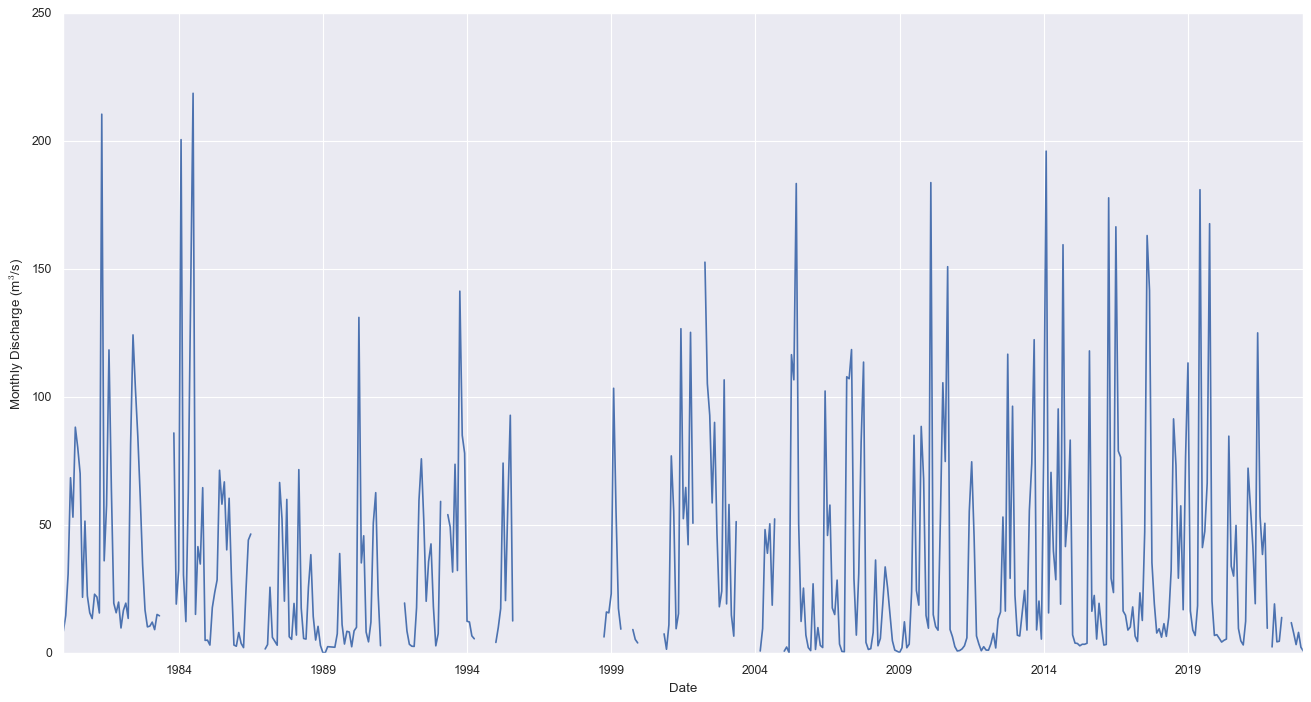

In [14]:
ax1 = DISCHARGE_MONTHLY['Discharge'].plot(figsize=(20, 10));
ax1.set_xlabel('Date');
ax1.set_ylabel('Monthly Discharge (m$^3$/s)');

Some description of monthly discharge time series

In [15]:
print('\nCantidad de meses de la serie: ',(len(DISCHARGE_MONTHLY['Year'])))
print('Cantidad de meses faltantes serie: ',np.isnan(DISCHARGE_MONTHLY['Discharge']).sum())
print('Cantidad de meses con datos en la serie: ',(len(DISCHARGE_MONTHLY['Year']))-np.isnan(DISCHARGE_MONTHLY['Discharge']).sum())
print()
print('Cantidad de años de la serie: ',(DISCHARGE_MONTHLY['Year'].max()-DISCHARGE_MONTHLY['Year'].min()))
print("Cantidad de meses faltante expresada en años:  {:.2f}".format((DISCHARGE_MONTHLY['Discharge'].isnull().sum()/DISCHARGE_MONTHLY['Discharge'].count())*(DISCHARGE_MONTHLY['Year'].max()-DISCHARGE_MONTHLY['Year'].min())))
print("Cantidad de meses con datos existentes expresada en años:  {:.2f}\n".format((DISCHARGE_MONTHLY['Year'].max()-DISCHARGE_MONTHLY['Year'].min())-(DISCHARGE_MONTHLY['Discharge'].isnull().sum()/DISCHARGE_MONTHLY['Discharge'].count())*(DISCHARGE_MONTHLY['Year'].max()-DISCHARGE_MONTHLY['Year'].min())))


Cantidad de meses de la serie:  517
Cantidad de meses faltantes serie:  100
Cantidad de meses con datos en la serie:  417

Cantidad de años de la serie:  43
Cantidad de meses faltante expresada en años:  10.31
Cantidad de meses con datos existentes expresada en años:  32.69



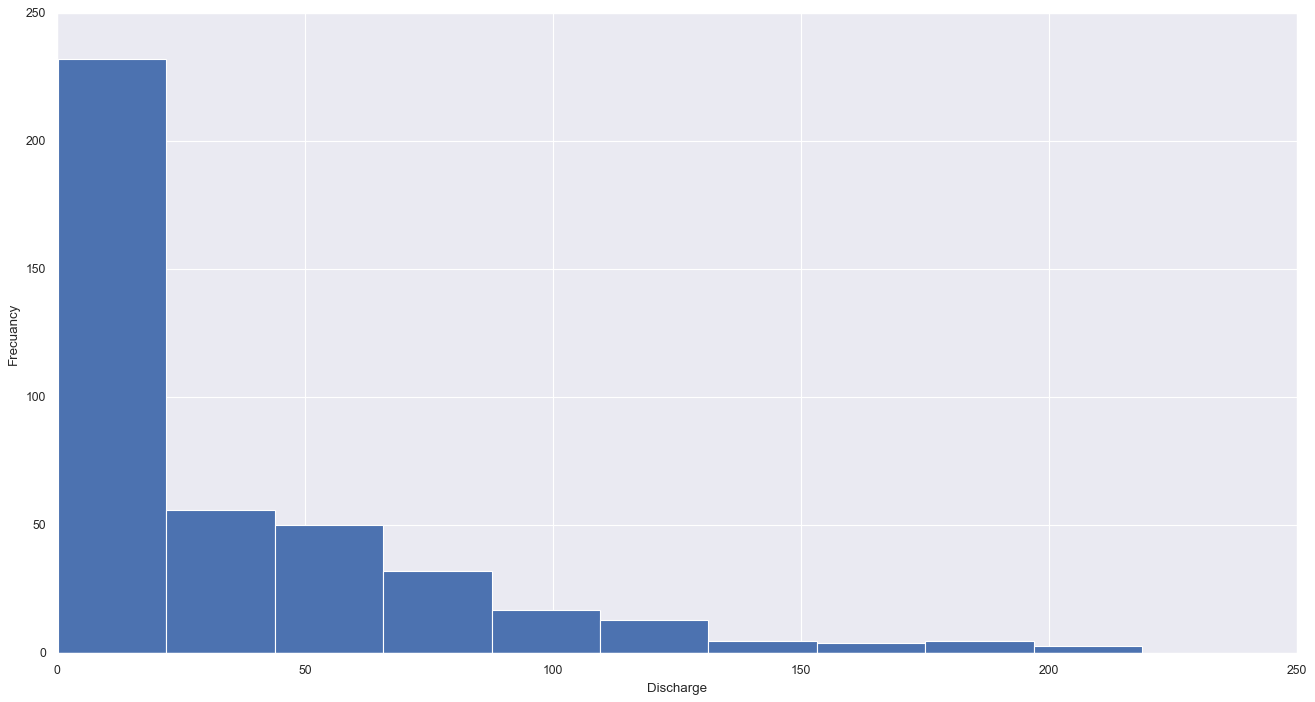

In [16]:
ax2 = DISCHARGE_MONTHLY['Discharge'].hist(figsize=(20, 10));
# ax2.set_xlim(-3.0,3.0)
ax2.set_xlabel('Discharge');
ax2.set_ylabel('Frecuancy');

<AxesSubplot: xlabel='None,Year'>

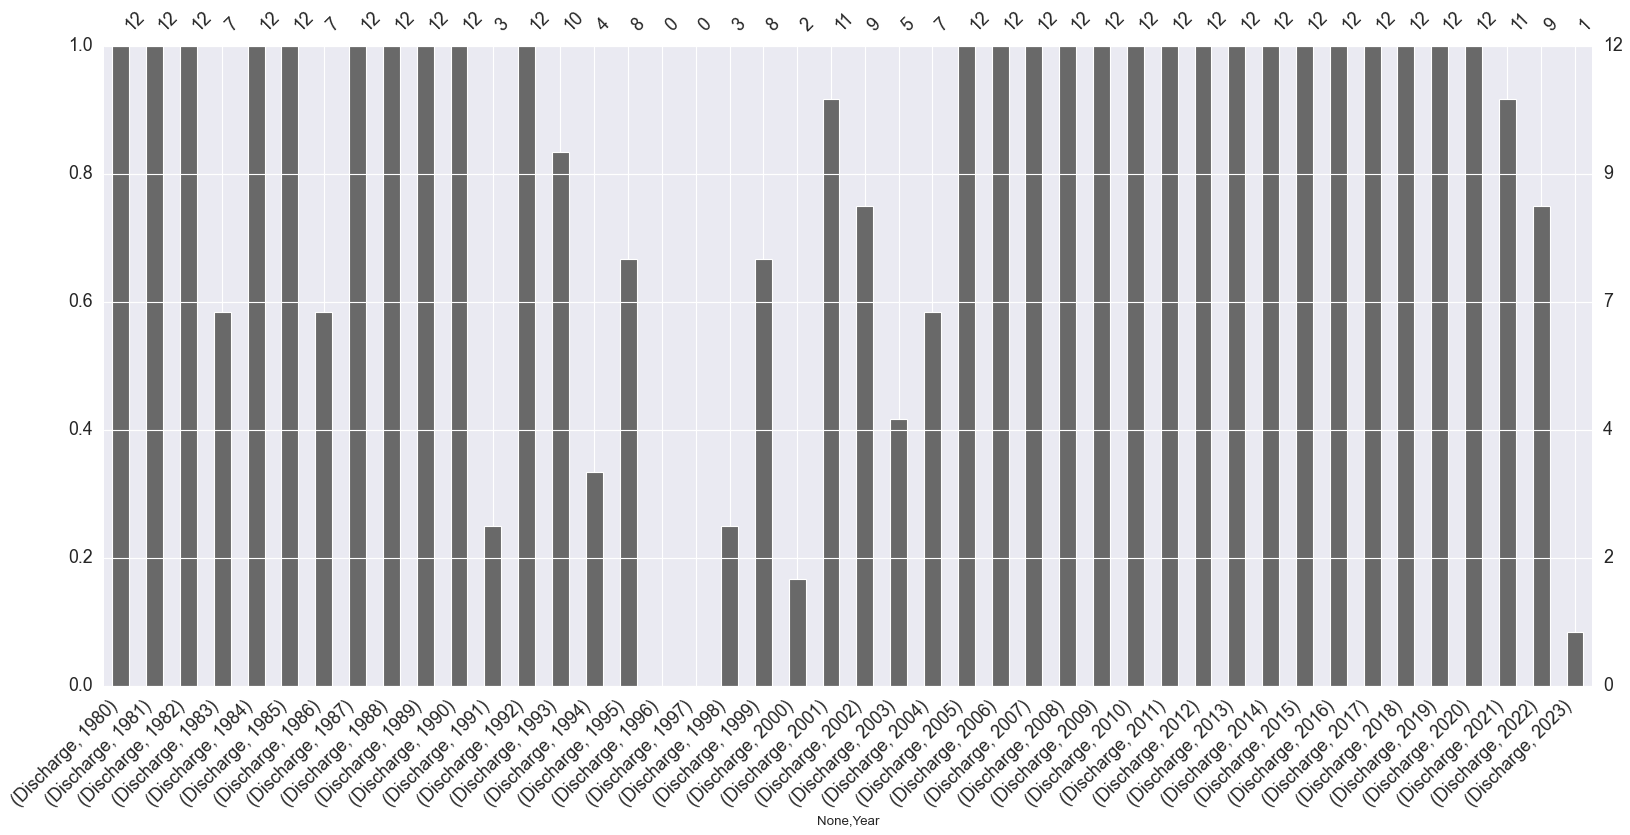

In [17]:
missingno.bar(pd.pivot_table(DISCHARGE_MONTHLY, index=['Month'],columns=['Year'], values=['Discharge'],dropna=False))

<AxesSubplot: xlabel='None,Month'>

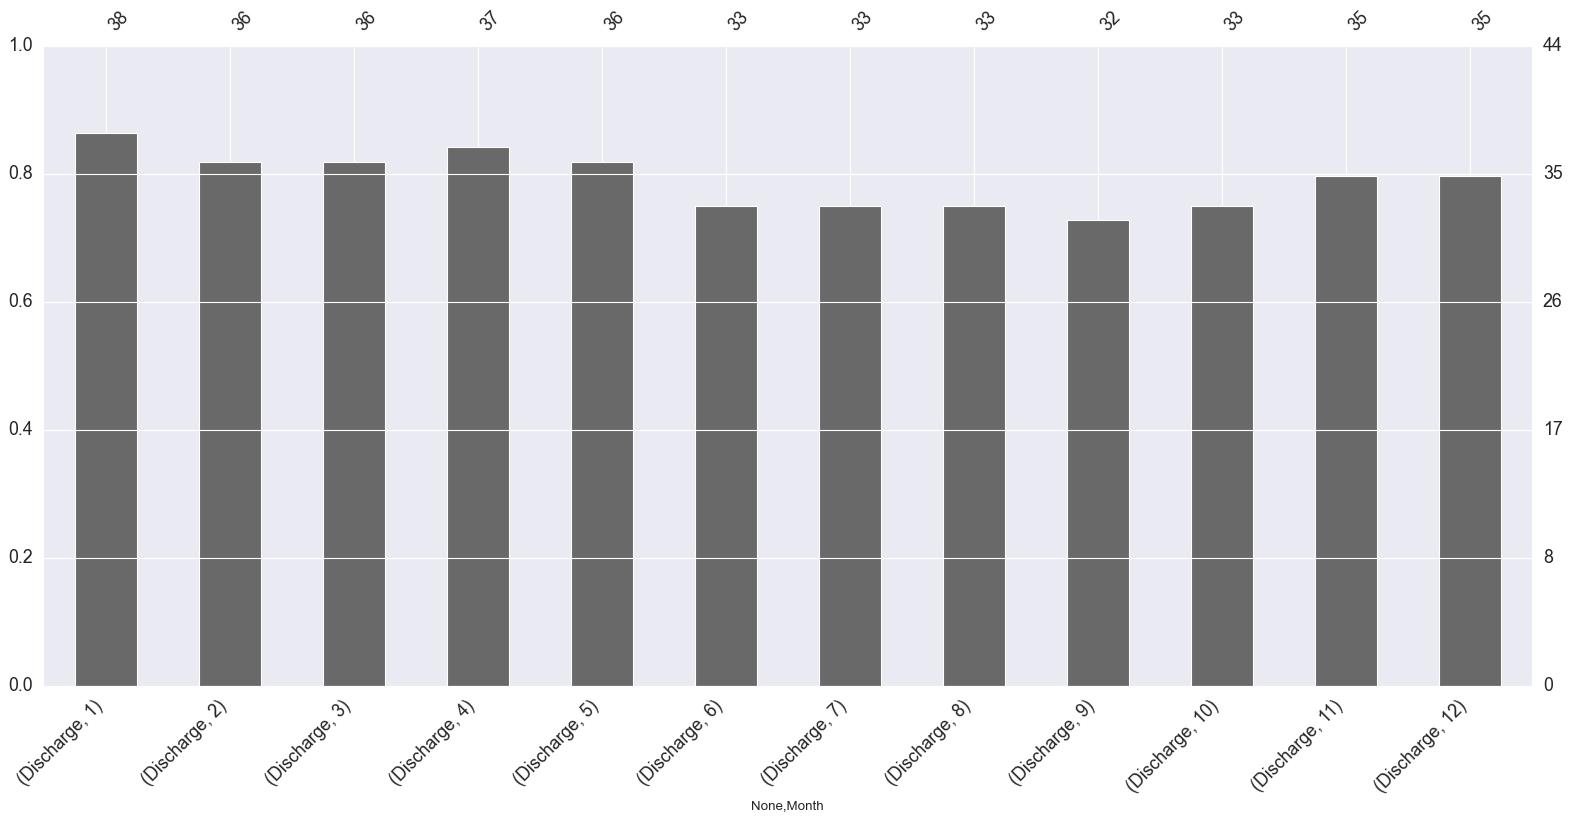

In [18]:
missingno.bar(pd.pivot_table(DISCHARGE_MONTHLY, index=['Year'],columns=['Month'], values=['Discharge'],dropna=False))

## Select by Climatology range

First, we transform the discharge to a logaritmic scale and we insert it in the dataframe

In [19]:
DISCHARGE_MONTHLY['Q_to_log'] = np.log(DISCHARGE_MONTHLY['Discharge'])

In [20]:
HTML(DISCHARGE_MONTHLY.tail(6).to_html(index=False))

Discharge,Year,Month,water_year,Q_to_log
11.981414,2022,8,2023,2.483357
7.823533,2022,9,2023,2.057136
3.412581,2022,10,2023,1.227469
8.174467,2022,11,2023,2.101015
2.383414,2022,12,2023,0.868534
0.893300,2023,1,2023,-0.112833


We plot a Histogram that show the Discharge distribution after the log-transformation

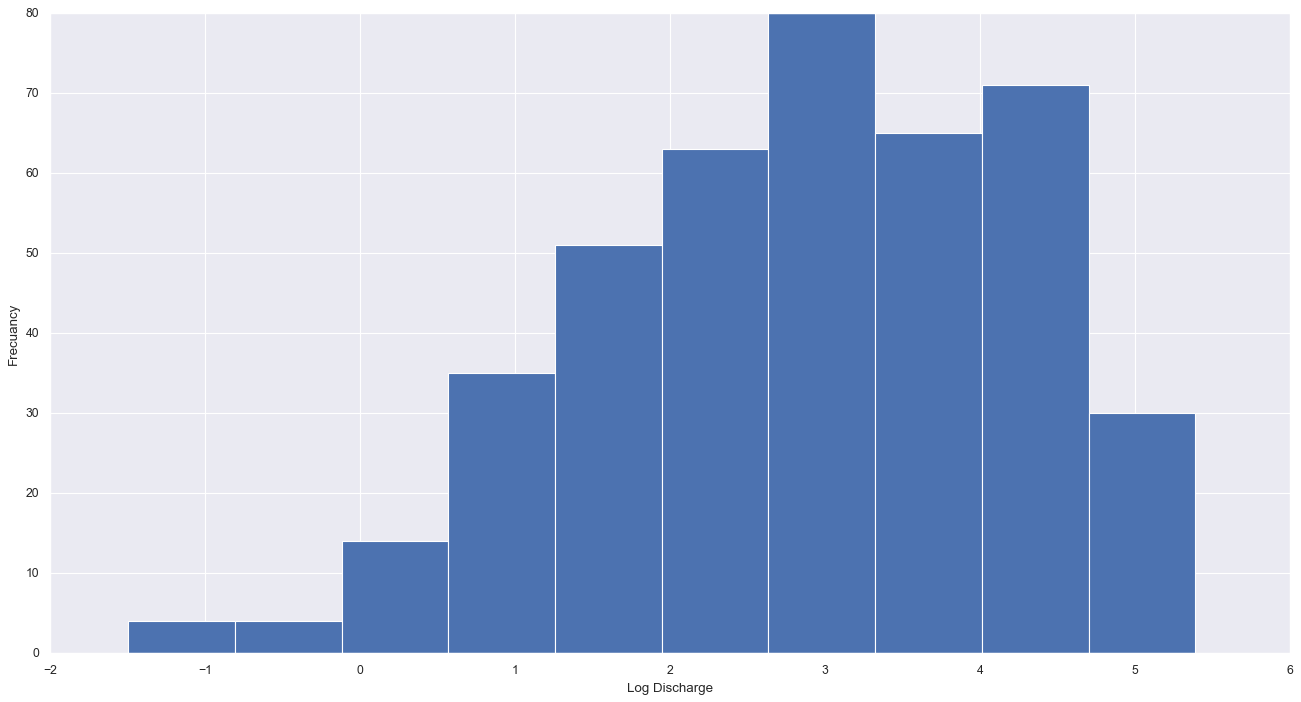

In [21]:
ax2 = DISCHARGE_MONTHLY['Q_to_log'].hist(figsize=(20, 10));
# ax2.set_xlim(-3.0,3.0)
ax2.set_xlabel('Log Discharge');
ax2.set_ylabel('Frecuancy');

In this part we select the reference period for analysis. In this case we use the 1980/01-2023/01 period

In [22]:
DISCHARGE_MONTHLY_SELECTED = DISCHARGE_MONTHLY.loc['1980-01-01':'2023-02-01']
HTML(DISCHARGE_MONTHLY_SELECTED.tail(6).to_html(index=False))

Discharge,Year,Month,water_year,Q_to_log
11.981414,2022,8,2023,2.483357
7.823533,2022,9,2023,2.057136
3.412581,2022,10,2023,1.227469
8.174467,2022,11,2023,2.101015
2.383414,2022,12,2023,0.868534
0.893300,2023,1,2023,-0.112833


Extract the years from the monthly discharge dataframe

In [23]:
YEAR_SELECTED = np.unique(DISCHARGE_MONTHLY_SELECTED['Year'])
display(YEAR_SELECTED)

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype=int64)

Plot the monthly log Discharge in a BoxPlot Graph

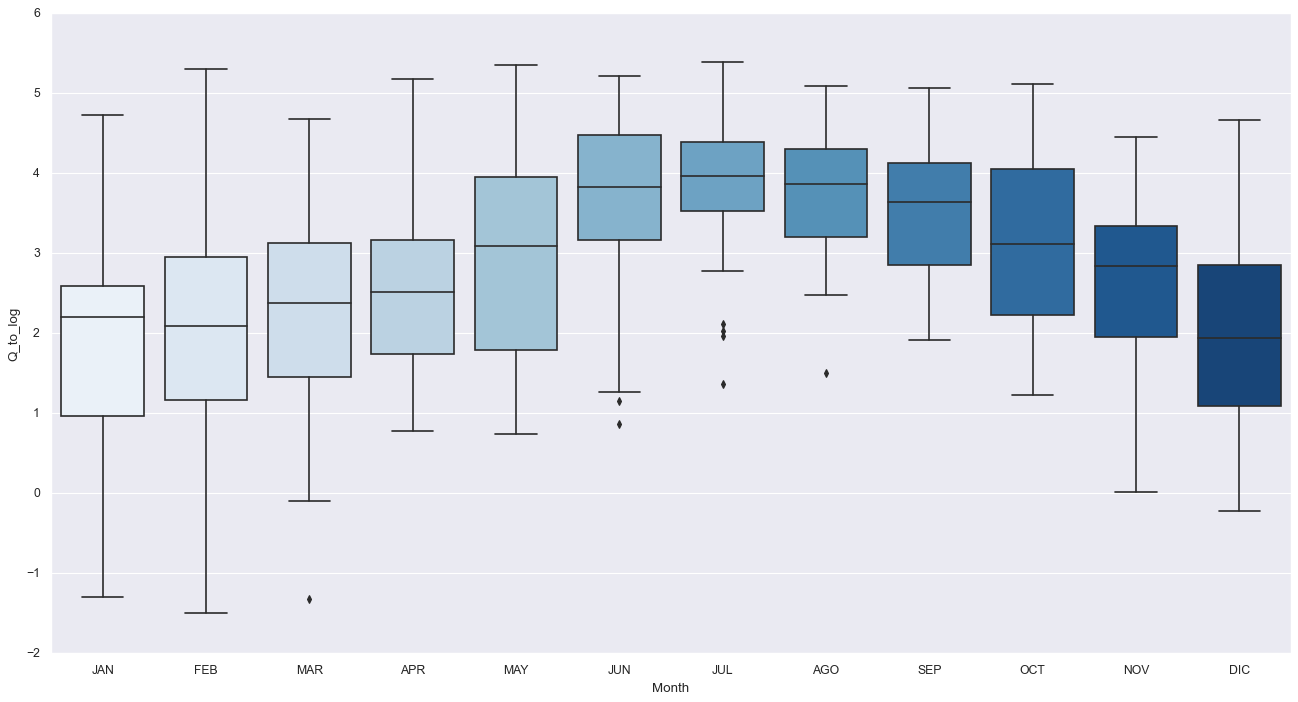

In [24]:
ax3 = plt.figure(figsize=(20, 10))
#ax3 = sns.boxplot(data = DISCHARGE_MONTHLY_SELECTED, x='Month', y='Q_to_log');
ax3 = sns.boxplot(data = DISCHARGE_MONTHLY_SELECTED, x='Month', y='Q_to_log',palette="Blues"); 
#ax3 = sns.boxplot(data = DISCHARGE_MONTHLY_SELECTED, x='Month', y='Q_to_log',color='skyblue');
ax3.set_xticklabels(['JAN','FEB','MAR','APR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC']);

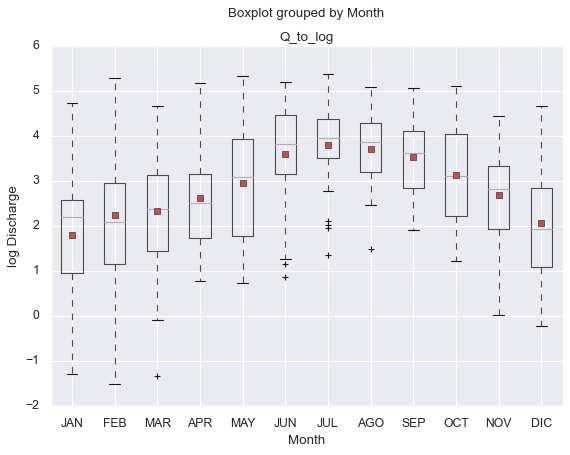

In [25]:
ax = DISCHARGE_MONTHLY_SELECTED.boxplot(column='Q_to_log',by='Month',showmeans=True)
#ax.set_xlim(0,13)
#ax.set_ylim(-3,3)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12],labels=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC'])
ax.set_xlabel('Month');
ax.set_ylabel('log Discharge');

## Calculate Monthly statistics for Q Log-transformed 

In this part we calculate monthly statistcs for the QLog Variable.

 The statistis include: mean, min, max, std, q1(quantile 0.28), q3(quantile 0.72), q5(0.05), q95(0.95), q87(0.87), q13(0.13)

In [26]:
DISCHARGE_MONTHLY_STATS = DISCHARGE_MONTHLY_SELECTED.Q_to_log.groupby(DISCHARGE_MONTHLY_SELECTED.index.month).agg([np.min, q1, q2, np.mean, q3, np.max, np.std, q95, q5, q87, q13])
# Display results
HTML(DISCHARGE_MONTHLY_STATS.to_html())

,amin,q1,q2,mean,q3,amax,std,q95,q5,q87,q13
Fecha,,,,,,,,,,,
1,-1.290750,1.046466,2.209093,1.808731,2.527604,4.731068,1.413708,3.614124,-0.453201,3.127862,-0.084559
2,-1.497226,1.220797,2.094013,2.241336,2.834962,5.301624,1.645925,5.230404,-0.059804,4.310156,0.623355
3,-1.324138,1.538069,2.384297,2.330038,2.998487,4.682407,1.275285,4.101348,0.394365,3.785092,1.130550
4,0.776063,1.837815,2.517543,2.625081,2.881443,5.181330,1.299243,4.907254,0.899154,4.425690,1.086245
5,0.738968,2.121641,3.094483,2.956500,3.890605,5.349930,1.235505,4.697518,0.874192,4.259049,1.424871
6,0.865432,3.177168,3.826904,3.613409,4.442261,5.212272,1.173055,5.044288,1.219486,4.828691,2.262110
7,1.370091,3.713525,3.962580,3.818021,4.317981,5.387990,0.896575,4.842631,2.005821,4.554441,2.854860
8,1.500976,3.242027,3.863568,3.709396,4.297419,5.094999,0.803961,4.773043,2.506998,4.428530,2.757091
9,1.914149,2.916117,3.639343,3.543018,4.010039,5.072685,0.851082,4.982383,2.256204,4.411863,2.668846


We plot the median, 28th and 72th percentile

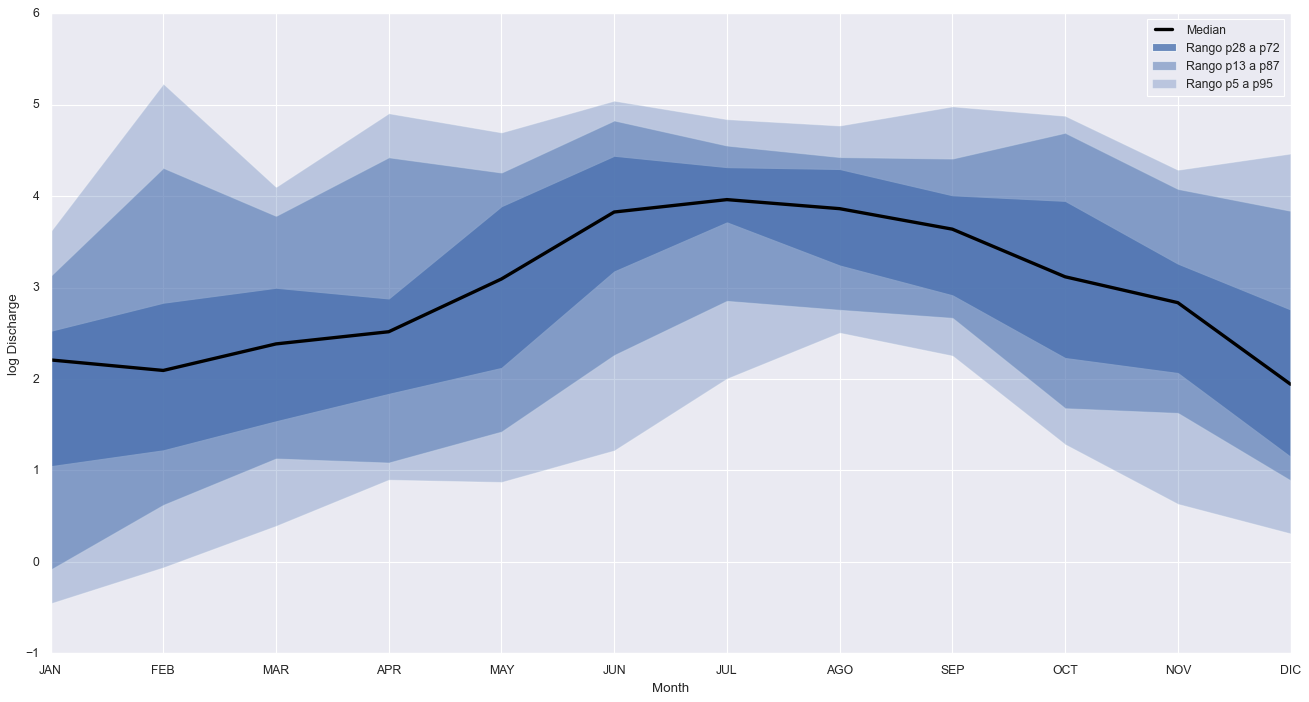

In [27]:
plt.figure(figsize=(20, 10))
plt.plot(DISCHARGE_MONTHLY_STATS.index,DISCHARGE_MONTHLY_STATS['q2'], '-',color='black',lw='3')
# plt.fill_between(monthly_sst.index, monthly_sst['q2'] + monthly_sst['std'], monthly_sst['q2'] - monthly_sst['std'],alpha=0.3)
plt.fill_between(DISCHARGE_MONTHLY_STATS.index, DISCHARGE_MONTHLY_STATS['q1'], DISCHARGE_MONTHLY_STATS['q3'],alpha=0.8)
plt.fill_between(DISCHARGE_MONTHLY_STATS.index, DISCHARGE_MONTHLY_STATS['q13'], DISCHARGE_MONTHLY_STATS['q87'],alpha=0.5)
plt.fill_between(DISCHARGE_MONTHLY_STATS.index, DISCHARGE_MONTHLY_STATS['q5'], DISCHARGE_MONTHLY_STATS['q95'],alpha=0.3)

plt.xlim(1,12)
plt.xticks(DISCHARGE_MONTHLY_STATS.index,labels=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC']);
plt.legend(['Median','Rango p28 a p72','Rango p13 a p87','Rango p5 a p95'])
plt.xlabel('Month');
plt.ylabel('log Discharge');

## Calculate Daily statistics

We reproduce the same procedure for the Daily dataframe

In [28]:
DISCHARGE_DAILY_STATS = DISCHARGE_DAILY.Discharge.groupby(DISCHARGE_DAILY.monthday).agg([np.min, q1, q2, np.mean, q3, np.max, np.std, q5, q95, q87, q13])
HTML(DISCHARGE_DAILY_STATS.head(12).to_html())

,amin,q1,q2,mean,q3,amax,std,q5,q95,q87,q13
monthday,,,,,,,,,,,
1,0.296,1.65724,3.379,16.767359,11.16840,167.914,34.185302,0.6047,95.0932,28.11858,1.35522
2,0.287,1.72040,4.141,11.022897,11.25216,101.886,19.276825,0.6007,32.8343,15.35908,1.26286
3,0.247,1.71036,3.855,13.133154,10.79568,160.855,27.889588,0.5944,50.8391,18.26842,1.18268
4,0.204,1.71052,4.400,18.246282,9.81056,248.637,49.464161,0.5964,48.5906,18.86206,1.07826
5,0.182,1.82704,5.088,9.622410,10.08852,78.540,14.555780,0.5290,27.7146,17.70086,1.11074
6,0.161,1.73392,5.456,7.260205,9.71768,38.359,7.659597,0.3215,19.3012,13.19506,1.06428
7,0.157,1.76220,5.801,15.206051,10.19924,220.998,39.221107,0.2832,41.3795,15.95276,1.02642
8,0.167,1.48240,5.512,39.763282,8.26908,1088.709,176.728067,0.6306,46.8633,12.89914,0.95080
9,0.162,1.91644,4.168,24.800949,8.10400,593.058,97.641433,0.6927,32.7194,10.89684,1.01448


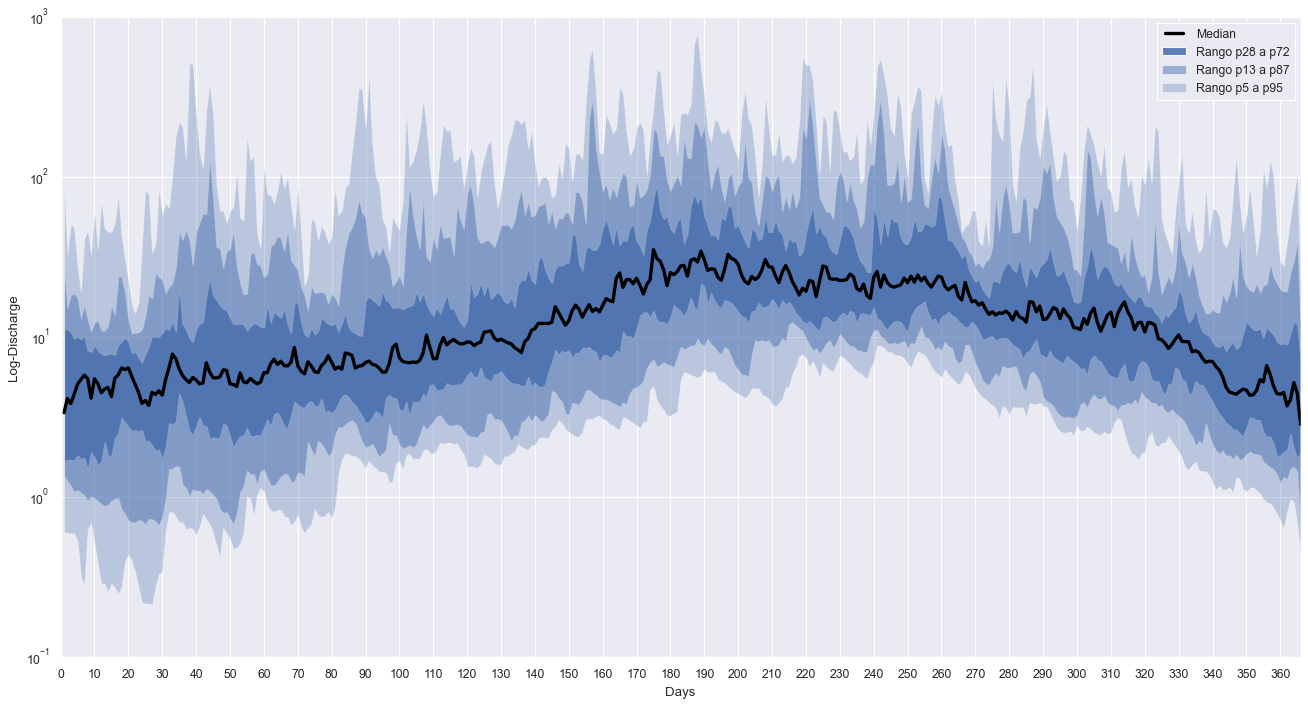

In [29]:
plt.figure(figsize=(20, 10))
plt.plot(DISCHARGE_DAILY_STATS.index,DISCHARGE_DAILY_STATS['q2'], '-',color='black',lw='3')
# plt.fill_between(monthly_sst.index, monthly_sst['q2'] + monthly_sst['std'], monthly_sst['q2'] - monthly_sst['std'],alpha=0.3)
plt.fill_between(DISCHARGE_DAILY_STATS.index, DISCHARGE_DAILY_STATS['q1'], DISCHARGE_DAILY_STATS['q3'],alpha=0.9)
plt.fill_between(DISCHARGE_DAILY_STATS.index, DISCHARGE_DAILY_STATS['q13'], DISCHARGE_DAILY_STATS['q87'],alpha=0.5)
plt.fill_between(DISCHARGE_DAILY_STATS.index, DISCHARGE_DAILY_STATS['q5'], DISCHARGE_DAILY_STATS['q95'],alpha=0.3)
plt.xlim(1,366)
plt.xticks(np.arange(0, 366, 10.0))
plt.yscale('log')
# plt.xticks(monthly_sst.index,labels=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC']);
plt.legend(['Median','Rango p28 a p72','Rango p13 a p87','Rango p5 a p95',])
plt.xlabel('Days');
plt.ylabel('Log-Discharge');

We re-shape the monthly log discharge dataframe using a pivot table for the Discharge (pivQ) and the log Discharge (pivLogQ)

In [30]:
DISCHARGE_MONTHLY_PIVOT = pd.pivot_table(DISCHARGE_MONTHLY_SELECTED, index=['Month'],columns=['Year'], values=['Discharge'],dropna=False)

In [31]:
DISCHARGE_MONTHLY_PIVOT.columns = YEAR_SELECTED
HTML(DISCHARGE_MONTHLY_PIVOT.to_html())

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,8.646161,13.581484,9.905548,10.620677,32.405355,5.157516,2.771871,1.715871,19.493484,0.285581,2.569323,2.987290,3.539774,7.706581,12.525419,4.259419,NaN,NaN,NaN,23.307645,NaN,11.126290,NaN,19.319710,NaN,0.857742,27.166032,0.731968,1.815419,0.275065,9.810452,0.925032,1.271903,22.713387,80.130742,7.187774,10.201323,10.289355,9.593355,113.416677,7.294806,12.520000,19.302226,0.8933
2,14.756828,23.089821,16.765714,12.195714,200.662414,3.231786,8.138107,3.430607,7.129690,0.223750,8.777679,NaN,2.786034,59.324393,12.246679,10.087429,NaN,NaN,NaN,103.529679,NaN,77.122500,NaN,58.154536,NaN,2.469571,1.523286,0.603143,8.096793,2.201250,183.870750,1.092857,1.245690,7.085250,196.156964,3.999679,3.228931,18.128107,6.298929,16.566393,5.897069,72.336143,4.490714,NaN
3,30.993548,21.982065,19.600452,9.254645,30.611000,17.838548,3.868742,25.821806,71.751806,2.601226,10.161742,NaN,2.700935,NaN,6.826581,17.485000,NaN,NaN,NaN,55.484710,NaN,55.668645,NaN,14.947484,0.914258,0.266032,10.054613,108.029806,36.455000,12.315387,15.102935,1.743161,3.755677,6.760742,15.797903,3.848871,3.464613,6.743065,11.587935,9.119387,4.403387,57.057484,4.720871,NaN
4,68.594033,15.757933,13.647233,15.190633,12.398100,23.754033,2.232867,6.254233,17.661867,2.517133,131.210933,NaN,17.855567,NaN,5.691967,74.305633,NaN,NaN,NaN,17.519067,NaN,9.607900,152.786900,6.716767,9.695200,116.669367,3.091967,107.273900,2.949133,2.172900,10.439567,2.969733,7.834867,15.802400,70.689033,2.945333,177.919233,4.619933,6.620800,6.946400,5.099067,41.835933,13.998133,NaN
5,53.190742,210.593452,81.599839,14.660452,62.943000,28.678323,24.352323,4.686774,5.805774,2.445032,35.310968,NaN,59.820355,54.174000,NaN,20.622323,NaN,NaN,NaN,9.461536,NaN,15.505516,105.349032,51.440714,48.334645,106.835774,2.258258,118.652000,5.819097,3.590742,9.039419,6.060710,2.093774,24.564871,39.996387,3.547710,29.313129,23.631774,14.134710,18.586613,5.584000,19.378258,NaN,NaN
6,88.343367,36.137167,124.398400,NaN,139.929133,71.524667,44.253300,3.170967,5.566167,2.376033,45.920133,NaN,75.989467,49.293167,NaN,58.967733,NaN,NaN,NaN,NaN,NaN,126.796233,92.933967,NaN,39.083533,183.510500,102.458667,29.226500,19.289833,23.988667,53.430100,55.481933,13.423133,9.087500,28.745133,3.536433,23.742133,12.832233,32.404567,181.094033,84.828967,125.171067,NaN,NaN
7,80.379290,57.890613,103.427645,NaN,218.763226,58.263806,46.602258,66.730968,25.814355,7.651516,8.316742,NaN,51.935571,31.755129,NaN,92.980677,NaN,NaN,NaN,NaN,NaN,52.592839,58.753484,NaN,50.609226,50.782645,46.046548,7.114935,33.761161,85.168710,105.705774,74.822226,16.109645,55.764774,95.453613,3.935710,166.598548,47.444903,91.591000,41.316065,34.059290,53.535548,NaN,NaN
8,70.239710,118.505645,84.750613,NaN,15.231065,66.974677,NaN,52.523871,38.537935,38.986032,4.486065,NaN,20.330516,73.863000,NaN,12.673581,NaN,NaN,NaN,NaN,NaN,64.791839,90.207710,NaN,18.808355,12.462935,57.918484,31.068290,25.629419,24.554484,74.939065,45.585323,53.255000,74.167484,19.212742,118.127516,79.029161,163.203677,73.495129,47.635032,30.170645,38.622258,11.981414,NaN
9,21.893533,64.170633,61.238333,NaN,41.675833,40.407467,NaN,20.373367,14.396633,11.235500,12.195800,NaN,35.861733,32.360926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.419767,46.817700,NaN,52.496767,25.478933,17.730167,82.609833,15.313433,18.827900,151.025733,6.781167,16.513800,122.502300,159.602233,16.427500,76.599433,141.697100,29.346767,66.525500,49.964833,50.809467,7.823533,NaN


In [32]:
LOG_DISCHARGE_MONTHLY_PIVOT = pd.pivot_table(DISCHARGE_MONTHLY_SELECTED, index=['Month'],columns=['Year'], values=['Q_to_log'],dropna=False)

Rename the columns based on the reference years

In [33]:
LOG_DISCHARGE_MONTHLY_PIVOT.columns = YEAR_SELECTED
HTML(LOG_DISCHARGE_MONTHLY_PIVOT.to_html())

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2.157115,2.608707,2.293095,2.362803,3.478324,1.640455,1.019523,0.539921,2.970080,-1.253231,0.943642,1.094367,1.264063,2.042075,2.527760,1.449133,NaN,NaN,NaN,3.148781,NaN,2.409311,NaN,2.961126,NaN,-0.153452,3.301967,-0.312019,0.596316,-1.290750,2.283448,-0.077927,0.240514,3.122954,4.383660,1.972382,2.322517,2.331110,2.261071,4.731068,1.987163,2.527327,2.960220,-0.112833
2,2.691706,3.139392,2.819336,2.501085,5.301624,1.173035,2.096558,1.232737,1.964268,-1.497226,2.172212,NaN,1.024619,4.083021,2.505255,2.311290,NaN,NaN,NaN,4.639858,NaN,4.345395,NaN,4.063104,NaN,0.904045,0.420870,-0.505601,2.091468,0.789025,5.214233,0.088795,0.219689,1.958015,5.278915,1.386214,1.172151,2.897464,1.840380,2.807376,1.774455,4.281324,1.502012,NaN
3,3.433779,3.090227,2.975553,2.225126,3.421359,2.881362,1.352929,3.251219,4.273213,0.955983,2.318630,NaN,0.993598,NaN,1.920824,2.861343,NaN,NaN,NaN,4.016107,NaN,4.019417,NaN,2.704543,-0.089642,-1.324138,2.308032,4.682407,3.596079,2.510849,2.714889,0.555700,1.323269,1.911133,2.759877,1.347780,1.242601,1.908514,2.449965,2.210403,1.482374,4.044059,1.551993,NaN
4,4.228206,2.757344,2.613537,2.720679,2.517543,3.167752,0.803286,1.833259,2.871408,0.923121,4.876806,NaN,2.882315,NaN,1.739056,4.308187,NaN,NaN,NaN,2.863290,NaN,2.262586,5.029044,1.904607,2.271631,4.759344,1.128807,4.675385,1.081511,0.776063,2.345603,1.088472,2.058584,2.760162,4.258290,1.080222,5.181330,1.530380,1.890216,1.938224,1.629058,3.733756,2.638924,NaN
5,3.973884,5.349930,4.401827,2.685154,4.142230,3.356142,3.192627,1.544745,1.758853,0.894058,3.564194,NaN,4.091346,3.992201,NaN,3.026374,NaN,NaN,NaN,2.247235,NaN,2.741196,4.657279,3.940430,3.878149,4.671293,0.814594,4.776195,1.761145,1.278359,2.201595,1.801827,0.738968,3.201317,3.688789,1.266302,3.378036,3.162592,2.648633,2.922442,1.719905,2.964152,NaN,NaN
6,4.481231,3.587322,4.823489,NaN,4.941136,4.270042,3.789930,1.154036,1.716707,0.865432,3.826904,NaN,4.330595,3.897785,NaN,4.076990,NaN,NaN,NaN,NaN,NaN,4.842581,4.531889,NaN,3.665701,5.212272,4.629459,3.375076,2.959578,3.177581,3.978374,4.016057,2.596980,2.206900,3.358468,1.263119,3.167251,2.551960,3.478299,5.199016,4.440637,4.829681,NaN,NaN
7,4.386757,4.058555,4.638872,NaN,5.387990,4.064981,3.841649,4.200669,3.250931,2.034904,2.118271,NaN,3.950004,3.458054,NaN,4.532392,NaN,NaN,NaN,NaN,NaN,3.962580,4.073350,NaN,3.924134,3.927555,3.829653,1.962196,3.519311,4.444634,4.660660,4.315115,2.779418,4.021142,4.558640,1.370091,5.115587,3.859569,4.517333,3.721251,3.528103,3.980346,NaN,NaN
8,4.251914,4.774961,4.439713,NaN,2.723337,4.204315,NaN,3.961268,3.651643,3.663203,1.500976,NaN,3.012123,4.302212,NaN,2.539520,NaN,NaN,NaN,NaN,NaN,4.171180,4.502115,NaN,2.934301,2.522759,4.059037,3.436188,3.243741,3.200894,4.316675,3.819586,3.975092,4.306326,2.955574,4.771765,4.369817,5.094999,4.297219,3.863568,3.406869,3.653829,2.483357,NaN
9,3.086191,4.161546,4.114773,NaN,3.729921,3.699015,NaN,3.014228,2.666994,2.419078,2.501092,NaN,3.579671,3.476952,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.747614,3.846261,NaN,3.960752,3.237852,2.875268,4.414129,2.728730,2.935340,5.017450,1.914149,2.804196,4.808130,5.072685,2.798957,4.338590,4.953692,3.379182,4.197585,3.911319,3.928083,2.057136,NaN


## Calculate the standarised monthly anomalies

After creating the dataframe that includes a multi-year monthly log discharge, we calculate the monthly anomalies using the mean and standard deviation

In [34]:
MONTHLY_ANOMALY = pd.DataFrame()
for n in YEAR_SELECTED:
    data = (LOG_DISCHARGE_MONTHLY_PIVOT[n] - DISCHARGE_MONTHLY_STATS['mean'])/DISCHARGE_MONTHLY_STATS['std']
    MONTHLY_ANOMALY[n] = data

In [35]:
MONTHLY_ANOMALY

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
Month,,,,,,,,,,,,,,,,,,,,,
1,0.246433,0.565871,0.342619,0.391928,1.181002,-0.119032,-0.558254,-0.897505,0.821491,-2.165909,...,1.821400,0.115760,0.363432,0.369510,0.319967,2.067143,0.126215,0.508306,0.814517,-1.359237
2,0.273627,0.545624,0.351170,0.157813,1.859312,-0.649058,-0.087962,-0.612785,-0.168336,-2.271405,...,1.845515,-0.519539,-0.649595,0.398638,-0.243606,0.343904,-0.283658,1.239417,-0.449185,NaN
3,0.865486,0.596094,0.506173,-0.082266,0.855747,0.432314,-0.766188,0.722334,1.523719,-1.077449,...,0.337054,-0.770226,-0.852701,-0.330533,0.094039,-0.093810,-0.664686,1.344030,-0.610095,NaN
4,1.233892,0.101800,-0.008885,0.073580,-0.082769,0.417683,-1.402197,-0.609449,0.189593,-1.309963,...,1.257047,-1.189045,1.967491,-0.842568,-0.565610,-0.528660,-0.766618,0.853324,0.010655,NaN
5,0.823457,1.937208,1.169828,-0.219624,0.959713,0.323464,0.191118,-1.142655,-0.969359,-1.669311,...,0.592705,-1.368022,0.341185,0.166808,-0.249183,-0.027566,-1.000882,0.006193,NaN,NaN
6,0.739797,-0.022238,1.031563,NaN,1.131854,0.559764,0.150480,-2.096553,-1.616891,-2.342581,...,-0.217330,-2.003563,-0.380338,-0.904858,-0.115177,1.351691,0.705191,1.036842,NaN,NaN
7,0.634343,0.268281,0.915541,NaN,1.751074,0.275448,0.026353,0.426789,-0.632508,-1.988811,...,0.826054,-2.730314,1.447248,0.046341,0.779982,-0.107933,-0.323362,0.181050,NaN,NaN
8,0.674806,1.325393,0.908398,NaN,-1.226501,0.615600,NaN,0.313288,-0.071836,-0.057456,...,-0.937635,1.321417,0.821458,1.723469,0.731158,0.191766,-0.376295,-0.069117,-1.524998,NaN
9,-0.536759,0.726755,0.671798,NaN,0.219607,0.183293,NaN,-0.621314,-1.029305,-1.320600,...,1.797320,-0.874252,0.934777,1.657506,-0.192502,0.769100,0.432745,0.452442,-1.745873,NaN


re-write the index from 1 to 12 (JAN to DEC)

In [36]:
MONTHLY_ANOMALY.index = np.arange(1, len(MONTHLY_ANOMALY) + 1)
HTML(MONTHLY_ANOMALY.to_html())

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,0.246433,0.565871,0.342619,0.391928,1.181002,-0.119032,-0.558254,-0.897505,0.821491,-2.165909,-0.611929,-0.505313,-0.385276,0.165058,0.508612,-0.254365,NaN,NaN,NaN,0.947897,NaN,0.424826,NaN,0.815157,NaN,-1.387969,1.056255,-1.500133,-0.857613,-2.192448,0.335796,-1.334546,-1.109293,0.929629,1.821400,0.115760,0.363432,0.369510,0.319967,2.067143,0.126215,0.508306,0.814517,-1.359237
2,0.273627,0.545624,0.351170,0.157813,1.859312,-0.649058,-0.087962,-0.612785,-0.168336,-2.271405,-0.041997,NaN,-0.739230,1.118936,0.160347,0.042501,NaN,NaN,NaN,1.457249,NaN,1.278344,NaN,1.106835,NaN,-0.812486,-1.106044,-1.668932,-0.091054,-0.882367,1.806216,-1.307800,-1.228274,-0.172135,1.845515,-0.519539,-0.649595,0.398638,-0.243606,0.343904,-0.283658,1.239417,-0.449185,NaN
3,0.865486,0.596094,0.506173,-0.082266,0.855747,0.432314,-0.766188,0.722334,1.523719,-1.077449,-0.008945,NaN,-1.047954,NaN,-0.320880,0.416617,NaN,NaN,NaN,1.322112,NaN,1.324708,NaN,0.293664,-1.897364,-2.865380,-0.017256,1.844584,0.992752,0.141781,0.301777,-1.391326,-0.789446,-0.328480,0.337054,-0.770226,-0.852701,-0.330533,0.094039,-0.093810,-0.664686,1.344030,-0.610095,NaN
4,1.233892,0.101800,-0.008885,0.073580,-0.082769,0.417683,-1.402197,-0.609449,0.189593,-1.309963,1.733106,NaN,0.197988,NaN,-0.681955,1.295452,NaN,NaN,NaN,0.183345,NaN,-0.279005,1.850280,-0.554534,-0.272043,1.642698,-1.151650,1.578077,-1.188053,-1.423151,-0.215108,-1.182696,-0.436021,0.103969,1.257047,-1.189045,1.967491,-0.842568,-0.565610,-0.528660,-0.766618,0.853324,0.010655,NaN
5,0.823457,1.937208,1.169828,-0.219624,0.959713,0.323464,0.191118,-1.142655,-0.969359,-1.669311,0.491859,NaN,0.918528,0.838282,NaN,0.056555,NaN,NaN,NaN,-0.574069,NaN,-0.174264,1.376587,0.796379,0.745970,1.387929,-1.733629,1.472836,-0.967503,-1.358264,-0.611009,-0.934576,-1.794839,0.198152,0.592705,-1.368022,0.341185,0.166808,-0.249183,-0.027566,-1.000882,0.006193,NaN,NaN
6,0.739797,-0.022238,1.031563,NaN,1.131854,0.559764,0.150480,-2.096553,-1.616891,-2.342581,0.181999,NaN,0.611383,0.242424,NaN,0.395192,NaN,NaN,NaN,NaN,NaN,1.047839,0.782982,NaN,0.044578,1.362991,0.866158,-0.203173,-0.557374,-0.371532,0.311124,0.343248,-0.866480,-1.199013,-0.217330,-2.003563,-0.380338,-0.904858,-0.115177,1.351691,0.705191,1.036842,NaN,NaN
7,0.634343,0.268281,0.915541,NaN,1.751074,0.275448,0.026353,0.426789,-0.632508,-1.988811,-1.895827,NaN,0.147208,-0.401491,NaN,0.796778,NaN,NaN,NaN,NaN,NaN,0.161235,0.284783,NaN,0.118354,0.122169,0.012973,-2.069906,-0.333168,0.698897,0.939842,0.554437,-1.158412,0.226553,0.826054,-2.730314,1.447248,0.046341,0.779982,-0.107933,-0.323362,0.181050,NaN,NaN
8,0.674806,1.325393,0.908398,NaN,-1.226501,0.615600,NaN,0.313288,-0.071836,-0.057456,-2.746924,NaN,-0.867297,0.737369,NaN,-1.455140,NaN,NaN,NaN,NaN,NaN,0.574385,0.986016,NaN,-0.964095,-1.475988,0.434897,-0.339828,-0.579201,-0.632495,0.755359,0.137058,0.330483,0.742486,-0.937635,1.321417,0.821458,1.723469,0.731158,0.191766,-0.376295,-0.069117,-1.524998,NaN
9,-0.536759,0.726755,0.671798,NaN,0.219607,0.183293,NaN,-0.621314,-1.029305,-1.320600,-1.224236,NaN,0.043067,-0.077626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.240396,0.356304,NaN,0.490827,-0.358562,-0.784589,1.023533,-0.956767,-0.714006,1.732421,-1.913879,-0.868096,1.486475,1.797320,-0.874252,0.934777,1.657506,-0.192502,0.769100,0.432745,0.452442,-1.745873,NaN
10,0.675993,-0.144178,0.337564,NaN,0.344257,0.810697,NaN,0.804191,-1.265752,-1.567117,0.664472,NaN,0.516144,1.527402,NaN,NaN,NaN,NaN,-1.087165,-0.774208,NaN,1.425341,-0.206289,NaN,NaN,-0.998871,-0.360460,1.343163,-1.310581,1.132370,-0.772710,-1.575410,1.365743,-0.787208,0.495185,-0.021956,-0.285265,0.357970,0.768400,1.671744,-0.735074,-0.728273,-1.620122,NaN


Plot the monthly anomalies log discharge

Standarised monthly anomalies

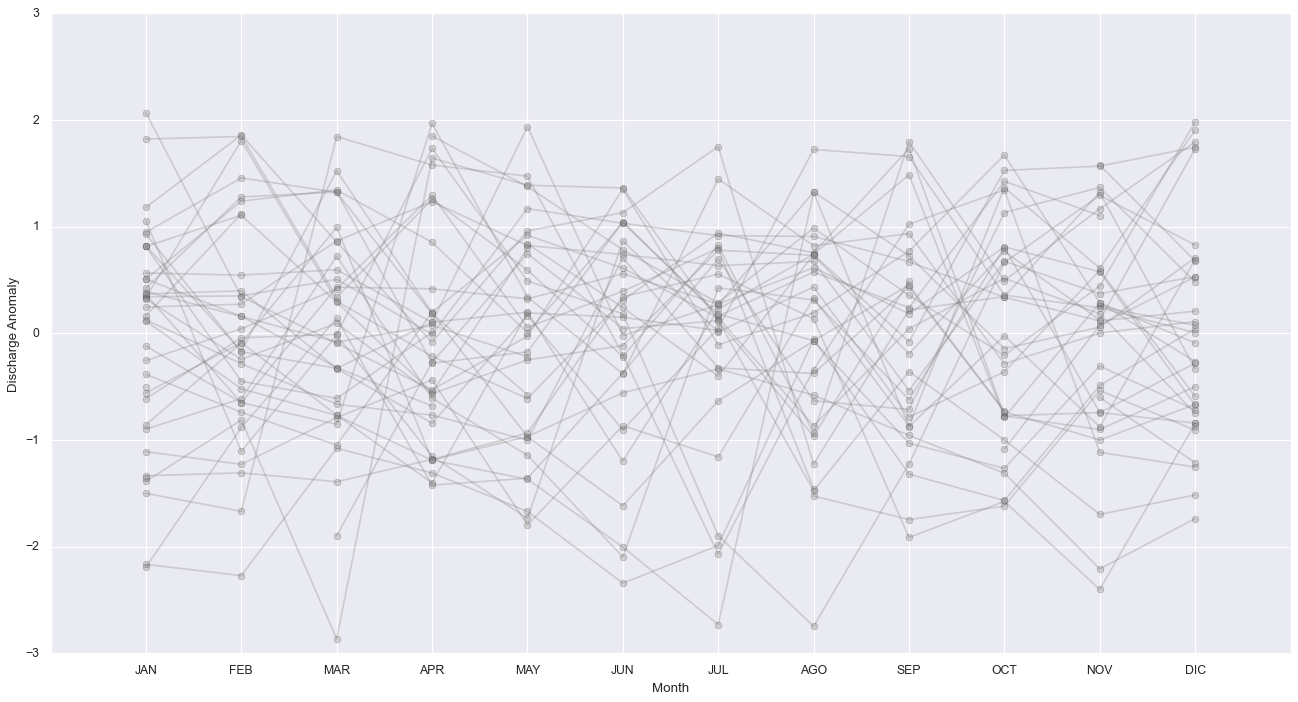

In [37]:
ax = MONTHLY_ANOMALY.plot(kind="line",style = 'o-',color='gray',legend=None,figsize=(20, 10),alpha=0.3)
ax.set_xlim(0,13)
ax.set_ylim(-3,3)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12],labels=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC'])
ax.set_xlabel('Month');
ax.set_ylabel('Discharge Anomaly');

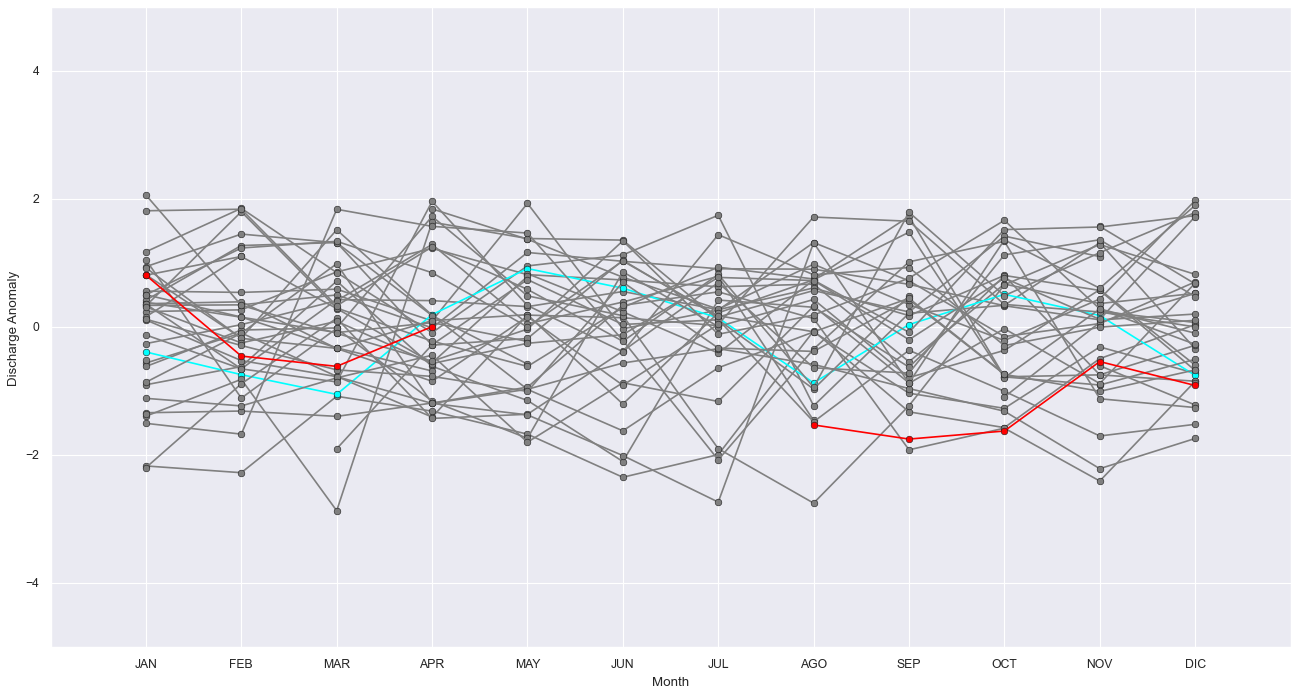

In [38]:
color_dict = {2022:'red', 1992:'cyan'}

ax4 = MONTHLY_ANOMALY.plot(color=[color_dict.get(x,'gray') for x in MONTHLY_ANOMALY.columns],legend=None,kind="line",style = 'o-',figsize=(20, 10))
ax4.set_xlim(0,13)
ax4.set_ylim(-5,5)
ax4.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12],labels=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC'])
ax4.set_xlabel('Month');
ax4.set_ylabel('Discharge Anomaly');


Text(0, 0.5, 'Discharge Anomaly')

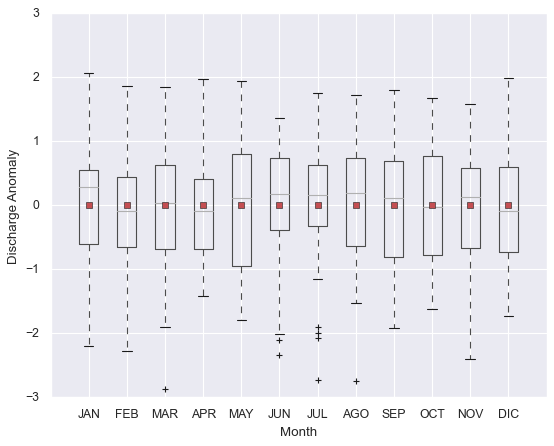

In [39]:
ax = MONTHLY_ANOMALY.T.boxplot(showmeans=True)
ax.set_xlim(0,13)
ax.set_ylim(-3,3)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12],labels=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AGO','SEP','OCT','NOV','DIC'])
ax.set_xlabel('Month');
ax.set_ylabel('Discharge Anomaly')

## Persistence forecast

We create a function called add_month that add the number of months based on an input date. This will be used in the Jack-Knife Validation

In [40]:
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

We import the monthly river flow anomalies from 1980 to 2023 

In [41]:
ANOMALY_PERSISTENCE = MONTHLY_ANOMALY[range(1980,2024,1)]
QLOG_PERSISTENCE = LOG_DISCHARGE_MONTHLY_PIVOT[range(1980,2024,1)]
HTML(ANOMALY_PERSISTENCE.to_html())

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,0.246433,0.565871,0.342619,0.391928,1.181002,-0.119032,-0.558254,-0.897505,0.821491,-2.165909,-0.611929,-0.505313,-0.385276,0.165058,0.508612,-0.254365,NaN,NaN,NaN,0.947897,NaN,0.424826,NaN,0.815157,NaN,-1.387969,1.056255,-1.500133,-0.857613,-2.192448,0.335796,-1.334546,-1.109293,0.929629,1.821400,0.115760,0.363432,0.369510,0.319967,2.067143,0.126215,0.508306,0.814517,-1.359237
2,0.273627,0.545624,0.351170,0.157813,1.859312,-0.649058,-0.087962,-0.612785,-0.168336,-2.271405,-0.041997,NaN,-0.739230,1.118936,0.160347,0.042501,NaN,NaN,NaN,1.457249,NaN,1.278344,NaN,1.106835,NaN,-0.812486,-1.106044,-1.668932,-0.091054,-0.882367,1.806216,-1.307800,-1.228274,-0.172135,1.845515,-0.519539,-0.649595,0.398638,-0.243606,0.343904,-0.283658,1.239417,-0.449185,NaN
3,0.865486,0.596094,0.506173,-0.082266,0.855747,0.432314,-0.766188,0.722334,1.523719,-1.077449,-0.008945,NaN,-1.047954,NaN,-0.320880,0.416617,NaN,NaN,NaN,1.322112,NaN,1.324708,NaN,0.293664,-1.897364,-2.865380,-0.017256,1.844584,0.992752,0.141781,0.301777,-1.391326,-0.789446,-0.328480,0.337054,-0.770226,-0.852701,-0.330533,0.094039,-0.093810,-0.664686,1.344030,-0.610095,NaN
4,1.233892,0.101800,-0.008885,0.073580,-0.082769,0.417683,-1.402197,-0.609449,0.189593,-1.309963,1.733106,NaN,0.197988,NaN,-0.681955,1.295452,NaN,NaN,NaN,0.183345,NaN,-0.279005,1.850280,-0.554534,-0.272043,1.642698,-1.151650,1.578077,-1.188053,-1.423151,-0.215108,-1.182696,-0.436021,0.103969,1.257047,-1.189045,1.967491,-0.842568,-0.565610,-0.528660,-0.766618,0.853324,0.010655,NaN
5,0.823457,1.937208,1.169828,-0.219624,0.959713,0.323464,0.191118,-1.142655,-0.969359,-1.669311,0.491859,NaN,0.918528,0.838282,NaN,0.056555,NaN,NaN,NaN,-0.574069,NaN,-0.174264,1.376587,0.796379,0.745970,1.387929,-1.733629,1.472836,-0.967503,-1.358264,-0.611009,-0.934576,-1.794839,0.198152,0.592705,-1.368022,0.341185,0.166808,-0.249183,-0.027566,-1.000882,0.006193,NaN,NaN
6,0.739797,-0.022238,1.031563,NaN,1.131854,0.559764,0.150480,-2.096553,-1.616891,-2.342581,0.181999,NaN,0.611383,0.242424,NaN,0.395192,NaN,NaN,NaN,NaN,NaN,1.047839,0.782982,NaN,0.044578,1.362991,0.866158,-0.203173,-0.557374,-0.371532,0.311124,0.343248,-0.866480,-1.199013,-0.217330,-2.003563,-0.380338,-0.904858,-0.115177,1.351691,0.705191,1.036842,NaN,NaN
7,0.634343,0.268281,0.915541,NaN,1.751074,0.275448,0.026353,0.426789,-0.632508,-1.988811,-1.895827,NaN,0.147208,-0.401491,NaN,0.796778,NaN,NaN,NaN,NaN,NaN,0.161235,0.284783,NaN,0.118354,0.122169,0.012973,-2.069906,-0.333168,0.698897,0.939842,0.554437,-1.158412,0.226553,0.826054,-2.730314,1.447248,0.046341,0.779982,-0.107933,-0.323362,0.181050,NaN,NaN
8,0.674806,1.325393,0.908398,NaN,-1.226501,0.615600,NaN,0.313288,-0.071836,-0.057456,-2.746924,NaN,-0.867297,0.737369,NaN,-1.455140,NaN,NaN,NaN,NaN,NaN,0.574385,0.986016,NaN,-0.964095,-1.475988,0.434897,-0.339828,-0.579201,-0.632495,0.755359,0.137058,0.330483,0.742486,-0.937635,1.321417,0.821458,1.723469,0.731158,0.191766,-0.376295,-0.069117,-1.524998,NaN
9,-0.536759,0.726755,0.671798,NaN,0.219607,0.183293,NaN,-0.621314,-1.029305,-1.320600,-1.224236,NaN,0.043067,-0.077626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.240396,0.356304,NaN,0.490827,-0.358562,-0.784589,1.023533,-0.956767,-0.714006,1.732421,-1.913879,-0.868096,1.486475,1.797320,-0.874252,0.934777,1.657506,-0.192502,0.769100,0.432745,0.452442,-1.745873,NaN
10,0.675993,-0.144178,0.337564,NaN,0.344257,0.810697,NaN,0.804191,-1.265752,-1.567117,0.664472,NaN,0.516144,1.527402,NaN,NaN,NaN,NaN,-1.087165,-0.774208,NaN,1.425341,-0.206289,NaN,NaN,-0.998871,-0.360460,1.343163,-1.310581,1.132370,-0.772710,-1.575410,1.365743,-0.787208,0.495185,-0.021956,-0.285265,0.357970,0.768400,1.671744,-0.735074,-0.728273,-1.620122,NaN


In [42]:
ANOMALY_PERSISTENCE_TS = pd.melt(ANOMALY_PERSISTENCE.reset_index(), id_vars='index',var_name=['Year'],ignore_index = True)
ANOMALY_PERSISTENCE_TS.columns = ['Month','Year','Anomaly_Qlog']
HTML(ANOMALY_PERSISTENCE_TS.head(6).to_html())

,Month,Year,Anomaly_Qlog
0,1,1980,0.246433
1,2,1980,0.273627
2,3,1980,0.865486
3,4,1980,1.233892
4,5,1980,0.823457
5,6,1980,0.739797


In [43]:
QLOG_PERSISTENCE_TS = pd.melt(QLOG_PERSISTENCE.reset_index(), id_vars='Month',var_name=['Year'],ignore_index = True)
QLOG_PERSISTENCE_TS.columns = ['Month','Year','Qlog']
HTML(QLOG_PERSISTENCE_TS.head(6).to_html())

,Month,Year,Qlog
0,1,1980,2.157115
1,2,1980,2.691706
2,3,1980,3.433779
3,4,1980,4.228206
4,5,1980,3.973884
5,6,1980,4.481231


### Jack-knife validation

In this section, we will apply Jack Knife verification for each year and for each month of that year. The Jack Knife verification is a method that drop one year and calculate the forecast using the remaining of the years. 

Performance is based on “jack-knife” hindcasts for the period of observations available at each station. This involves dropping 1 year at a time from the record, and forecasting the flow anomalies in this missing year using the remaining years in the record. In this way, a hindcast will be made for each year which can be compared with the flow anomaly that was actually observed in that year. For each method, the correlation between its hindcast record and the observed record is calculated for each calendar month, and is used as a measure of its performance.

In [44]:
# Select the year of analysis
YEAR_ANALYSIS = range(1980,2024,1)
MONTH_ANALYSIS = range(1,13,1)

# Create empty dataframe
ANOMALY_HINDCAST_PERSISTENCE = pd.DataFrame()
HINDCAST_MONTHS_PERSISTENCE = pd.DataFrame()
HINDCAST_STATS_QLOG_PERSISTENCE = pd.DataFrame()
HINDCAST_STATS_ANOMALY_PERSISTENCE = pd.DataFrame()
RESCALE_FORECAST_PERSISTENCE =  ANOMALY_PERSISTENCE_TS
SCALE_FORECAST_PERSISTENCE = ANOMALY_PERSISTENCE_TS

# Make the resample 
for y in YEAR_ANALYSIS:
    # extract the monthly anomalies for the corresponding year of analysis
    ANOMALY_YEAR = ANOMALY_PERSISTENCE[y].to_frame()

    # From the Qlog values, drop the monthly values for the year of analysis and mantain the remaining years. 
    # This is the Qlog hindcast series
    QLOG_HINDCAST_PERSISTENCE= QLOG_PERSISTENCE.drop([y],axis=1)
    QLOG_HINDCAST_PERSISTENCE_TS = QLOG_PERSISTENCE_TS[QLOG_PERSISTENCE_TS['Year'] != y]
    # From the monthly anomaly values, drop the monthly values for the year of analysis and mantain the remaining years. 
    # This is the anomaly hindcast series
    ANOMALY_HINDCAST_PERSISTENCE = ANOMALY_PERSISTENCE.drop([y],axis=1)
    # Calculate statistic for the hindcast Qlog serie
    HINDCAST_STATS_QLOG_PERSISTENCE['mean'] = np.mean(QLOG_HINDCAST_PERSISTENCE,axis=1)
    HINDCAST_STATS_QLOG_PERSISTENCE['std'] = np.std(QLOG_HINDCAST_PERSISTENCE,axis=1)
    # Calculate statistic for the hindcast Anomaly serie
    HINDCAST_STATS_ANOMALY_PERSISTENCE['mean'] = np.mean(ANOMALY_HINDCAST_PERSISTENCE,axis=1)
    HINDCAST_STATS_ANOMALY_PERSISTENCE['std'] = np.std(ANOMALY_HINDCAST_PERSISTENCE,axis=1)

    # for each year of analysis, we are going to iterate by each month (1 to 12)
    for m in MONTH_ANALYSIS:
        print('Dropping year:',y,"-","End-Month:",m)
        # extract from the hindcast series, all the corresponding monthly values based on the month of analysis. After this, it transpose the table  
        HINDCAST_MONTHS_PERSISTENCE = ANOMALY_HINDCAST_PERSISTENCE.loc[[m]].T
        # Obtain the Anomaly value for the end month (analysis)
        ANOMALY_ANALYSIS_PERSISTENCE = ANOMALY_YEAR.query('index==@m')[y].item()
        # Create a datetime that consider the current year and month
        END_MONTH = datetime.date.today().replace(year=y, month=m, day=1)
        # Using the add_month function, we add n lead month for the forecast
        ONE_MONTH = add_months(END_MONTH,1)
        TWO_MONTH = add_months(END_MONTH,2)
        THREE_MONTH = add_months(END_MONTH,3)
        SIX_MONTH = add_months(END_MONTH,6)
        # Do the forecast using persistence method. 
        SCALE_FORECAST_PERSISTENCE.loc[SCALE_FORECAST_PERSISTENCE.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'1_monthFcst'] = float(ANOMALY_ANALYSIS_PERSISTENCE)
        SCALE_FORECAST_PERSISTENCE.loc[SCALE_FORECAST_PERSISTENCE.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'2_monthFcst'] = float(ANOMALY_ANALYSIS_PERSISTENCE)
        SCALE_FORECAST_PERSISTENCE.loc[SCALE_FORECAST_PERSISTENCE.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'3_monthFcst'] = float(ANOMALY_ANALYSIS_PERSISTENCE)
        SCALE_FORECAST_PERSISTENCE.loc[SCALE_FORECAST_PERSISTENCE.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'6_monthFcst'] = float(ANOMALY_ANALYSIS_PERSISTENCE)
        # re-standardised all the month of analysis from the hindcast series based on the mean and standard deviation.
        ANOMALY_RESCALE_HINDCAST_PERSISTENCE = (HINDCAST_MONTHS_PERSISTENCE - np.mean(HINDCAST_MONTHS_PERSISTENCE,axis=0))/np.std(HINDCAST_MONTHS_PERSISTENCE,axis=0)
        # Re-standardised the qlog discharge anomaly of the current month 
        ANOMALY_RESCALE_ANALYSIS_PERSISTENCE = (ANOMALY_ANALYSIS_PERSISTENCE - np.mean(HINDCAST_MONTHS_PERSISTENCE,axis=0))/np.std(HINDCAST_MONTHS_PERSISTENCE,axis=0)
        # Store the rescale forecast, mean and std (1-month)
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'1_monthFcst'] = float(ANOMALY_RESCALE_ANALYSIS_PERSISTENCE)
        QLOG_MONTH_PERSISTENCE = QLOG_HINDCAST_PERSISTENCE_TS.query("Month == @ONE_MONTH.month")
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'mean'] = float(np.mean(QLOG_MONTH_PERSISTENCE['Qlog'],axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'std'] = float(np.std(QLOG_MONTH_PERSISTENCE['Qlog'],axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'low'] = float(np.nanpercentile(QLOG_MONTH_PERSISTENCE['Qlog'],28,axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'medium'] = float(np.nanpercentile(QLOG_MONTH_PERSISTENCE['Qlog'],50,axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@ONE_MONTH.month & Year==@ONE_MONTH.year'),'high'] = float(np.nanpercentile(QLOG_MONTH_PERSISTENCE['Qlog'],72,axis=0))
        # Store the rescale forecast, mean and std (2-month)
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'2_monthFcst'] = float(ANOMALY_RESCALE_ANALYSIS_PERSISTENCE)
        QLOG_MONTH_02_PERSISTENCE = QLOG_HINDCAST_PERSISTENCE_TS.query("Month == @TWO_MONTH.month")
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'mean'] = float(np.mean(QLOG_MONTH_02_PERSISTENCE['Qlog'],axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'std'] = float(np.std(QLOG_MONTH_02_PERSISTENCE['Qlog'],axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'low'] = float(np.nanpercentile(QLOG_MONTH_02_PERSISTENCE['Qlog'],28,axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'medium'] = float(np.nanpercentile(QLOG_MONTH_02_PERSISTENCE['Qlog'],50,axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@TWO_MONTH.month & Year==@TWO_MONTH.year'),'high'] = float(np.nanpercentile(QLOG_MONTH_02_PERSISTENCE['Qlog'],72,axis=0))
        # Store the rescale forecast, mean and std (3-month)
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'3_monthFcst'] = float(ANOMALY_RESCALE_ANALYSIS_PERSISTENCE)
        QLOG_MONTH_03_PERSISTENCE = QLOG_HINDCAST_PERSISTENCE_TS.query("Month == @THREE_MONTH.month")
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'mean'] = float(np.mean(QLOG_MONTH_PERSISTENCE['Qlog'],axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'std'] = float(np.std(QLOG_MONTH_PERSISTENCE['Qlog'],axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'low'] = float(np.nanpercentile(QLOG_MONTH_PERSISTENCE['Qlog'],28,axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'medium'] = float(np.nanpercentile(QLOG_MONTH_PERSISTENCE['Qlog'],50,axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@THREE_MONTH.month & Year==@THREE_MONTH.year'),'high'] = float(np.nanpercentile(QLOG_MONTH_PERSISTENCE['Qlog'],72,axis=0))
        # Store the rescale forecast, mean and std (6-month)
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'6_monthFcst'] = float(ANOMALY_RESCALE_ANALYSIS_PERSISTENCE)
        QLOG_MONTH_06_PERSISTENCE = QLOG_HINDCAST_PERSISTENCE_TS.query("Month == @SIX_MONTH.month")
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'mean'] = float(np.mean(QLOG_MONTH_06_PERSISTENCE['Qlog'],axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'std'] = float(np.std(QLOG_MONTH_06_PERSISTENCE['Qlog'],axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'low'] = float(np.nanpercentile(QLOG_MONTH_06_PERSISTENCE['Qlog'],28,axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'medium'] = float(np.nanpercentile(QLOG_MONTH_06_PERSISTENCE['Qlog'],50,axis=0))
        RESCALE_FORECAST_PERSISTENCE.loc[RESCALE_FORECAST_PERSISTENCE.eval('Month==@SIX_MONTH.month & Year==@SIX_MONTH.year'),'high'] = float(np.nanpercentile(QLOG_MONTH_06_PERSISTENCE['Qlog'],72,axis=0))
        

Dropping year: 1980 - End-Month: 1
Dropping year: 1980 - End-Month: 2
Dropping year: 1980 - End-Month: 3
Dropping year: 1980 - End-Month: 4
Dropping year: 1980 - End-Month: 5
Dropping year: 1980 - End-Month: 6
Dropping year: 1980 - End-Month: 7
Dropping year: 1980 - End-Month: 8
Dropping year: 1980 - End-Month: 9
Dropping year: 1980 - End-Month: 10
Dropping year: 1980 - End-Month: 11
Dropping year: 1980 - End-Month: 12
Dropping year: 1981 - End-Month: 1
Dropping year: 1981 - End-Month: 2
Dropping year: 1981 - End-Month: 3
Dropping year: 1981 - End-Month: 4
Dropping year: 1981 - End-Month: 5
Dropping year: 1981 - End-Month: 6
Dropping year: 1981 - End-Month: 7
Dropping year: 1981 - End-Month: 8
Dropping year: 1981 - End-Month: 9
Dropping year: 1981 - End-Month: 10
Dropping year: 1981 - End-Month: 11
Dropping year: 1981 - End-Month: 12
Dropping year: 1982 - End-Month: 1
Dropping year: 1982 - End-Month: 2
Dropping year: 1982 - End-Month: 3
Dropping year: 1982 - End-Month: 4
Dropping year:

Dropping year: 1999 - End-Month: 7
Dropping year: 1999 - End-Month: 8
Dropping year: 1999 - End-Month: 9
Dropping year: 1999 - End-Month: 10
Dropping year: 1999 - End-Month: 11
Dropping year: 1999 - End-Month: 12
Dropping year: 2000 - End-Month: 1
Dropping year: 2000 - End-Month: 2
Dropping year: 2000 - End-Month: 3
Dropping year: 2000 - End-Month: 4
Dropping year: 2000 - End-Month: 5
Dropping year: 2000 - End-Month: 6
Dropping year: 2000 - End-Month: 7
Dropping year: 2000 - End-Month: 8
Dropping year: 2000 - End-Month: 9
Dropping year: 2000 - End-Month: 10
Dropping year: 2000 - End-Month: 11
Dropping year: 2000 - End-Month: 12
Dropping year: 2001 - End-Month: 1
Dropping year: 2001 - End-Month: 2
Dropping year: 2001 - End-Month: 3
Dropping year: 2001 - End-Month: 4
Dropping year: 2001 - End-Month: 5
Dropping year: 2001 - End-Month: 6
Dropping year: 2001 - End-Month: 7
Dropping year: 2001 - End-Month: 8
Dropping year: 2001 - End-Month: 9
Dropping year: 2001 - End-Month: 10
Dropping year

Dropping year: 2018 - End-Month: 12
Dropping year: 2019 - End-Month: 1
Dropping year: 2019 - End-Month: 2
Dropping year: 2019 - End-Month: 3
Dropping year: 2019 - End-Month: 4
Dropping year: 2019 - End-Month: 5
Dropping year: 2019 - End-Month: 6
Dropping year: 2019 - End-Month: 7
Dropping year: 2019 - End-Month: 8
Dropping year: 2019 - End-Month: 9
Dropping year: 2019 - End-Month: 10
Dropping year: 2019 - End-Month: 11
Dropping year: 2019 - End-Month: 12
Dropping year: 2020 - End-Month: 1
Dropping year: 2020 - End-Month: 2
Dropping year: 2020 - End-Month: 3
Dropping year: 2020 - End-Month: 4
Dropping year: 2020 - End-Month: 5
Dropping year: 2020 - End-Month: 6
Dropping year: 2020 - End-Month: 7
Dropping year: 2020 - End-Month: 8
Dropping year: 2020 - End-Month: 9
Dropping year: 2020 - End-Month: 10
Dropping year: 2020 - End-Month: 11
Dropping year: 2020 - End-Month: 12
Dropping year: 2021 - End-Month: 1
Dropping year: 2021 - End-Month: 2
Dropping year: 2021 - End-Month: 3
Dropping year

In [45]:
ANOMALY_PERSISTENCE

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,0.246433,0.565871,0.342619,0.391928,1.181002,-0.119032,-0.558254,-0.897505,0.821491,-2.165909,...,1.821400,0.115760,0.363432,0.369510,0.319967,2.067143,0.126215,0.508306,0.814517,-1.359237
2,0.273627,0.545624,0.351170,0.157813,1.859312,-0.649058,-0.087962,-0.612785,-0.168336,-2.271405,...,1.845515,-0.519539,-0.649595,0.398638,-0.243606,0.343904,-0.283658,1.239417,-0.449185,NaN
3,0.865486,0.596094,0.506173,-0.082266,0.855747,0.432314,-0.766188,0.722334,1.523719,-1.077449,...,0.337054,-0.770226,-0.852701,-0.330533,0.094039,-0.093810,-0.664686,1.344030,-0.610095,NaN
4,1.233892,0.101800,-0.008885,0.073580,-0.082769,0.417683,-1.402197,-0.609449,0.189593,-1.309963,...,1.257047,-1.189045,1.967491,-0.842568,-0.565610,-0.528660,-0.766618,0.853324,0.010655,NaN
5,0.823457,1.937208,1.169828,-0.219624,0.959713,0.323464,0.191118,-1.142655,-0.969359,-1.669311,...,0.592705,-1.368022,0.341185,0.166808,-0.249183,-0.027566,-1.000882,0.006193,NaN,NaN
6,0.739797,-0.022238,1.031563,NaN,1.131854,0.559764,0.150480,-2.096553,-1.616891,-2.342581,...,-0.217330,-2.003563,-0.380338,-0.904858,-0.115177,1.351691,0.705191,1.036842,NaN,NaN
7,0.634343,0.268281,0.915541,NaN,1.751074,0.275448,0.026353,0.426789,-0.632508,-1.988811,...,0.826054,-2.730314,1.447248,0.046341,0.779982,-0.107933,-0.323362,0.181050,NaN,NaN
8,0.674806,1.325393,0.908398,NaN,-1.226501,0.615600,NaN,0.313288,-0.071836,-0.057456,...,-0.937635,1.321417,0.821458,1.723469,0.731158,0.191766,-0.376295,-0.069117,-1.524998,NaN
9,-0.536759,0.726755,0.671798,NaN,0.219607,0.183293,NaN,-0.621314,-1.029305,-1.320600,...,1.797320,-0.874252,0.934777,1.657506,-0.192502,0.769100,0.432745,0.452442,-1.745873,NaN
10,0.675993,-0.144178,0.337564,NaN,0.344257,0.810697,NaN,0.804191,-1.265752,-1.567117,...,0.495185,-0.021956,-0.285265,0.357970,0.768400,1.671744,-0.735074,-0.728273,-1.620122,NaN


In [46]:
ANOMALY_HINDCAST_PERSISTENCE

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
1,0.246433,0.565871,0.342619,0.391928,1.181002,-0.119032,-0.558254,-0.897505,0.821491,-2.165909,...,0.929629,1.821400,0.115760,0.363432,0.369510,0.319967,2.067143,0.126215,0.508306,0.814517
2,0.273627,0.545624,0.351170,0.157813,1.859312,-0.649058,-0.087962,-0.612785,-0.168336,-2.271405,...,-0.172135,1.845515,-0.519539,-0.649595,0.398638,-0.243606,0.343904,-0.283658,1.239417,-0.449185
3,0.865486,0.596094,0.506173,-0.082266,0.855747,0.432314,-0.766188,0.722334,1.523719,-1.077449,...,-0.328480,0.337054,-0.770226,-0.852701,-0.330533,0.094039,-0.093810,-0.664686,1.344030,-0.610095
4,1.233892,0.101800,-0.008885,0.073580,-0.082769,0.417683,-1.402197,-0.609449,0.189593,-1.309963,...,0.103969,1.257047,-1.189045,1.967491,-0.842568,-0.565610,-0.528660,-0.766618,0.853324,0.010655
5,0.823457,1.937208,1.169828,-0.219624,0.959713,0.323464,0.191118,-1.142655,-0.969359,-1.669311,...,0.198152,0.592705,-1.368022,0.341185,0.166808,-0.249183,-0.027566,-1.000882,0.006193,NaN
6,0.739797,-0.022238,1.031563,NaN,1.131854,0.559764,0.150480,-2.096553,-1.616891,-2.342581,...,-1.199013,-0.217330,-2.003563,-0.380338,-0.904858,-0.115177,1.351691,0.705191,1.036842,NaN
7,0.634343,0.268281,0.915541,NaN,1.751074,0.275448,0.026353,0.426789,-0.632508,-1.988811,...,0.226553,0.826054,-2.730314,1.447248,0.046341,0.779982,-0.107933,-0.323362,0.181050,NaN
8,0.674806,1.325393,0.908398,NaN,-1.226501,0.615600,NaN,0.313288,-0.071836,-0.057456,...,0.742486,-0.937635,1.321417,0.821458,1.723469,0.731158,0.191766,-0.376295,-0.069117,-1.524998
9,-0.536759,0.726755,0.671798,NaN,0.219607,0.183293,NaN,-0.621314,-1.029305,-1.320600,...,1.486475,1.797320,-0.874252,0.934777,1.657506,-0.192502,0.769100,0.432745,0.452442,-1.745873
10,0.675993,-0.144178,0.337564,NaN,0.344257,0.810697,NaN,0.804191,-1.265752,-1.567117,...,-0.787208,0.495185,-0.021956,-0.285265,0.357970,0.768400,1.671744,-0.735074,-0.728273,-1.620122


In [47]:
RESCALE_FORECAST_PERSISTENCE.head(18)

,Month,Year,Anomaly_Qlog,1_monthFcst,2_monthFcst,3_monthFcst,6_monthFcst,mean,std,low,medium,high
0,1,1980,0.246433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1980,0.273627,0.253307,NaN,NaN,NaN,2.228468,1.644113,1.204080,2.091468,2.856837
2,3,1980,0.865486,0.281755,0.253307,NaN,NaN,2.298502,1.261170,1.518576,2.318630,2.926573
3,4,1980,1.233892,0.900177,0.281755,0.253307,NaN,2.580549,1.270693,1.814418,2.431573,2.873589
4,5,1980,0.823457,1.296660,0.900177,0.281755,NaN,2.927432,1.223132,2.009706,3.026374,3.779682
5,6,1980,0.739797,0.855551,1.296660,0.900177,NaN,3.586289,1.162664,3.174276,3.808417,4.365808
6,7,1980,0.634343,0.769734,0.855551,1.296660,0.253307,3.800248,0.890742,3.659444,3.956292,4.237292
7,8,1980,0.674806,0.658449,0.769734,0.855551,0.281755,3.692442,0.798041,3.230030,3.841577,4.298817
8,9,1980,-0.536759,0.701056,0.658449,0.769734,0.900177,3.557754,0.846990,2.899296,3.699015,4.053165
9,10,1980,0.675993,-0.556751,0.701056,0.658449,1.296660,3.119621,1.174591,2.229676,3.046323,3.970268


In [48]:
RESCALE_FORECAST_PERSISTENCE.tail(18)

,Month,Year,Anomaly_Qlog,1_monthFcst,2_monthFcst,3_monthFcst,6_monthFcst,mean,std,low,medium,high
510,7,2022,NaN,NaN,NaN,0.010951,0.844342,3.818021,0.882886,3.713525,3.962580,4.317981
511,8,2022,-1.524998,NaN,NaN,NaN,-0.463394,3.747710,0.773248,3.354668,3.912418,4.298817
512,9,2022,-1.745873,-1.635121,NaN,NaN,-0.630986,3.590949,0.806736,2.966895,3.699015,4.053165
513,10,2022,-1.620122,-1.901258,-1.635121,NaN,0.010951,3.204530,1.132183,2.260528,3.331354,3.979538
514,11,2022,-0.535129,-1.746238,-1.901258,-1.635121,NaN,2.714969,1.109679,2.058013,2.869182,3.304470
515,12,2022,-0.908354,-0.553271,-1.746238,-1.901258,NaN,2.098445,1.298781,1.179657,2.007442,2.761711
516,1,2023,-1.359237,-0.946974,-0.553271,-1.746238,NaN,1.777610,1.400630,1.025510,2.157115,2.517886
517,2,2023,NaN,-1.433206,-0.946974,-0.553271,-1.635121,2.241336,1.622904,1.220797,2.094013,2.834962
518,3,2023,NaN,NaN,-1.433206,-0.946974,-1.901258,2.330038,1.257448,1.538069,2.384297,2.998487
519,4,2023,NaN,NaN,NaN,-1.433206,-1.746238,2.625081,1.281565,1.837815,2.517543,2.881443


## Weighted mean analogue forecast

the monthly anomalies of the most recently past months are compared with all possible historical sequences of anomalies covering the same months of the year. That is, if the recent past covers, say, the months February to July, then potential analogues are sought only in the February to July sequences of the historical record

In [49]:
# Select the end-month and year
END_YEAR = 2023
END_MONTH = 1
END_DATE = datetime.date.today().replace(year=END_YEAR, month=END_MONTH, day=1)

# Define the first date. In this case it will be 9 months before end_data 
FIRST_DATE = add_months(END_DATE,-9)

In [50]:
ANOMALY_ANALOGUES = MONTHLY_ANOMALY[range(1980,2024,1)]
QLOG_ANALOGUES = LOG_DISCHARGE_MONTHLY_PIVOT[range(1980,2024,1)]
HTML(ANOMALY_ANALOGUES.to_html())

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
1,0.246433,0.565871,0.342619,0.391928,1.181002,-0.119032,-0.558254,-0.897505,0.821491,-2.165909,-0.611929,-0.505313,-0.385276,0.165058,0.508612,-0.254365,NaN,NaN,NaN,0.947897,NaN,0.424826,NaN,0.815157,NaN,-1.387969,1.056255,-1.500133,-0.857613,-2.192448,0.335796,-1.334546,-1.109293,0.929629,1.821400,0.115760,0.363432,0.369510,0.319967,2.067143,0.126215,0.508306,0.814517,-1.359237
2,0.273627,0.545624,0.351170,0.157813,1.859312,-0.649058,-0.087962,-0.612785,-0.168336,-2.271405,-0.041997,NaN,-0.739230,1.118936,0.160347,0.042501,NaN,NaN,NaN,1.457249,NaN,1.278344,NaN,1.106835,NaN,-0.812486,-1.106044,-1.668932,-0.091054,-0.882367,1.806216,-1.307800,-1.228274,-0.172135,1.845515,-0.519539,-0.649595,0.398638,-0.243606,0.343904,-0.283658,1.239417,-0.449185,NaN
3,0.865486,0.596094,0.506173,-0.082266,0.855747,0.432314,-0.766188,0.722334,1.523719,-1.077449,-0.008945,NaN,-1.047954,NaN,-0.320880,0.416617,NaN,NaN,NaN,1.322112,NaN,1.324708,NaN,0.293664,-1.897364,-2.865380,-0.017256,1.844584,0.992752,0.141781,0.301777,-1.391326,-0.789446,-0.328480,0.337054,-0.770226,-0.852701,-0.330533,0.094039,-0.093810,-0.664686,1.344030,-0.610095,NaN
4,1.233892,0.101800,-0.008885,0.073580,-0.082769,0.417683,-1.402197,-0.609449,0.189593,-1.309963,1.733106,NaN,0.197988,NaN,-0.681955,1.295452,NaN,NaN,NaN,0.183345,NaN,-0.279005,1.850280,-0.554534,-0.272043,1.642698,-1.151650,1.578077,-1.188053,-1.423151,-0.215108,-1.182696,-0.436021,0.103969,1.257047,-1.189045,1.967491,-0.842568,-0.565610,-0.528660,-0.766618,0.853324,0.010655,NaN
5,0.823457,1.937208,1.169828,-0.219624,0.959713,0.323464,0.191118,-1.142655,-0.969359,-1.669311,0.491859,NaN,0.918528,0.838282,NaN,0.056555,NaN,NaN,NaN,-0.574069,NaN,-0.174264,1.376587,0.796379,0.745970,1.387929,-1.733629,1.472836,-0.967503,-1.358264,-0.611009,-0.934576,-1.794839,0.198152,0.592705,-1.368022,0.341185,0.166808,-0.249183,-0.027566,-1.000882,0.006193,NaN,NaN
6,0.739797,-0.022238,1.031563,NaN,1.131854,0.559764,0.150480,-2.096553,-1.616891,-2.342581,0.181999,NaN,0.611383,0.242424,NaN,0.395192,NaN,NaN,NaN,NaN,NaN,1.047839,0.782982,NaN,0.044578,1.362991,0.866158,-0.203173,-0.557374,-0.371532,0.311124,0.343248,-0.866480,-1.199013,-0.217330,-2.003563,-0.380338,-0.904858,-0.115177,1.351691,0.705191,1.036842,NaN,NaN
7,0.634343,0.268281,0.915541,NaN,1.751074,0.275448,0.026353,0.426789,-0.632508,-1.988811,-1.895827,NaN,0.147208,-0.401491,NaN,0.796778,NaN,NaN,NaN,NaN,NaN,0.161235,0.284783,NaN,0.118354,0.122169,0.012973,-2.069906,-0.333168,0.698897,0.939842,0.554437,-1.158412,0.226553,0.826054,-2.730314,1.447248,0.046341,0.779982,-0.107933,-0.323362,0.181050,NaN,NaN
8,0.674806,1.325393,0.908398,NaN,-1.226501,0.615600,NaN,0.313288,-0.071836,-0.057456,-2.746924,NaN,-0.867297,0.737369,NaN,-1.455140,NaN,NaN,NaN,NaN,NaN,0.574385,0.986016,NaN,-0.964095,-1.475988,0.434897,-0.339828,-0.579201,-0.632495,0.755359,0.137058,0.330483,0.742486,-0.937635,1.321417,0.821458,1.723469,0.731158,0.191766,-0.376295,-0.069117,-1.524998,NaN
9,-0.536759,0.726755,0.671798,NaN,0.219607,0.183293,NaN,-0.621314,-1.029305,-1.320600,-1.224236,NaN,0.043067,-0.077626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.240396,0.356304,NaN,0.490827,-0.358562,-0.784589,1.023533,-0.956767,-0.714006,1.732421,-1.913879,-0.868096,1.486475,1.797320,-0.874252,0.934777,1.657506,-0.192502,0.769100,0.432745,0.452442,-1.745873,NaN
10,0.675993,-0.144178,0.337564,NaN,0.344257,0.810697,NaN,0.804191,-1.265752,-1.567117,0.664472,NaN,0.516144,1.527402,NaN,NaN,NaN,NaN,-1.087165,-0.774208,NaN,1.425341,-0.206289,NaN,NaN,-0.998871,-0.360460,1.343163,-1.310581,1.132370,-0.772710,-1.575410,1.365743,-0.787208,0.495185,-0.021956,-0.285265,0.357970,0.768400,1.671744,-0.735074,-0.728273,-1.620122,NaN


In [51]:
ANOMALY_ANALOGUE_TS = pd.melt(ANOMALY_ANALOGUES.reset_index(), id_vars='index',var_name=['Year'],ignore_index = True)
ANOMALY_ANALOGUE_TS.columns = ['Month','Year','Anomaly_Qlog']
HTML(ANOMALY_ANALOGUE_TS.head(6).to_html())

,Month,Year,Anomaly_Qlog
0,1,1980,0.246433
1,2,1980,0.273627
2,3,1980,0.865486
3,4,1980,1.233892
4,5,1980,0.823457
5,6,1980,0.739797


In [52]:
QLOG_ANALOGUE_TS = pd.melt(QLOG_ANALOGUES.reset_index(), id_vars='Month',var_name=['Year'],ignore_index = True)
QLOG_ANALOGUE_TS.columns = ['Month','Year','Qlog']
HTML(QLOG_ANALOGUE_TS.head(6).to_html())

,Month,Year,Qlog
0,1,1980,2.157115
1,2,1980,2.691706
2,3,1980,3.433779
3,4,1980,4.228206
4,5,1980,3.973884
5,6,1980,4.481231


Create a column with datetime values

In [53]:
ANOMALY_ANALOGUE_TS['DATE'] = pd.to_datetime(ANOMALY_ANALOGUE_TS[['Year', 'Month']].assign(DAY=1))
HTML(ANOMALY_ANALOGUE_TS.head(6).to_html(index=False))

Month,Year,Anomaly_Qlog,DATE
1,1980,0.246433,1980-01-01
2,1980,0.273627,1980-02-01
3,1980,0.865486,1980-03-01
4,1980,1.233892,1980-04-01
5,1980,0.823457,1980-05-01
6,1980,0.739797,1980-06-01


Query in the anomaly_analogue_ts the first date and end date

In [54]:
ANOMALY_NOW = ANOMALY_ANALOGUE_TS.query('DATE > @FIRST_DATE & DATE <= @END_DATE')
HTML(ANOMALY_NOW.to_html(index=False))

Month,Year,Anomaly_Qlog,DATE
5,2022,NaN,2022-05-01
6,2022,NaN,2022-06-01
7,2022,NaN,2022-07-01
8,2022,-1.524998,2022-08-01
9,2022,-1.745873,2022-09-01
10,2022,-1.620122,2022-10-01
11,2022,-0.535129,2022-11-01
12,2022,-0.908354,2022-12-01
1,2023,-1.359237,2023-01-01


Define a Root Mean Square Error Function. This function will be used to select the analogues years

In [55]:
def rmse(predictions,targets):
    return ((predictions - targets) ** 2).mean() ** 0.5

Set the year of analysis from 1981 to 2022

In [56]:
YEAR_ANALYSIS = range(1981,2024,1)

In [57]:
# create empty database and lists
df = pd.DataFrame()
ANOMALY_HISTORICAL = pd.DataFrame()
RMSE = []
ANO = []

for y in YEAR_ANALYSIS:
    # define end month and year based on the for-loop
    END_DATE_HIST = datetime.date.today().replace(year=y, month=END_MONTH, day=1)
    # 9 months before
    FIRST_DATE_HIST = add_months(END_DATE_HIST,-9)
    # query in the anomaly time serie the first date and end_date
    ANOMALY_HISTORIC = ANOMALY_ANALOGUE_TS.query('DATE > @FIRST_DATE_HIST & DATE <= @END_DATE_HIST')
    # create a dataframe (df) for the "preditec" (analogue) and "target" (current year)
    df['predicted'] = ANOMALY_HISTORIC["Anomaly_Qlog"].values
    df['target'] = ANOMALY_NOW["Anomaly_Qlog"].values
    # if there is missing data then escape the for-loop
    if df['predicted'].isnull().values.any() == False:
        # calculate the RMSE
        RMSE_val = rmse(df['predicted'],df['target'])
        # append in the empty lists
        RMSE.append(RMSE_val)
        ANO.append(y)
        ANOMALY_HISTORICAL[y] = df['predicted']
        # print('the year ',y, 'has a RMSE of:', round(RMSE,2))
    else:
        # print('the year ',y, 'has missing data')
        continue

Reset the index and change it to month name

In [58]:
df['predicted']

0         NaN
1         NaN
2         NaN
3   -1.524998
4   -1.745873
5   -1.620122
6   -0.535129
7   -0.908354
8   -1.359237
Name: predicted, dtype: float64

In [59]:
import calendar 

# ANOMALY_HISTORICAL.index = np.arange(FIRST_DATE_HIST.month + 1, END_DATE_HIST.month + 1)
#ANOMALY_HISTORICAL.index = [5,6,7,8,9,10,11,12,1]
ANOMALY_HISTORICAL.index = pd.date_range(add_months(FIRST_DATE_HIST,1),add_months(END_DATE_HIST,1),freq='M').month.to_list()
ANOMALY_HISTORICAL = ANOMALY_HISTORICAL.reset_index()
ANOMALY_HISTORICAL = ANOMALY_HISTORICAL.rename(columns={"index": "MONTH"})

ANOMALY_HISTORICAL['MONTH'] = ANOMALY_HISTORICAL['MONTH'].apply(lambda x: calendar.month_abbr[x])
HTML(ANOMALY_HISTORICAL.to_html(index=False))


MONTH,1981,1982,1983,1985,1986,1988,1989,1990,1991,1993,1994,2003,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
May,0.823457,1.937208,1.169828,0.959713,0.323464,-1.142655,-0.969359,-1.669311,0.491859,0.918528,0.838282,1.376587,1.387929,-1.733629,1.472836,-0.967503,-1.358264,-0.611009,-0.934576,-1.794839,0.198152,0.592705,-1.368022,0.341185,0.166808,-0.249183,-0.027566,-1.000882
Jun,0.739797,-0.022238,1.031563,1.131854,0.559764,-2.096553,-1.616891,-2.342581,0.181999,0.611383,0.242424,0.782982,1.362991,0.866158,-0.203173,-0.557374,-0.371532,0.311124,0.343248,-0.866480,-1.199013,-0.217330,-2.003563,-0.380338,-0.904858,-0.115177,1.351691,0.705191
Jul,0.634343,0.268281,0.915541,1.751074,0.275448,0.426789,-0.632508,-1.988811,-1.895827,0.147208,-0.401491,0.284783,0.122169,0.012973,-2.069906,-0.333168,0.698897,0.939842,0.554437,-1.158412,0.226553,0.826054,-2.730314,1.447248,0.046341,0.779982,-0.107933,-0.323362
Aug,0.674806,1.325393,0.908398,-1.226501,0.615600,0.313288,-0.071836,-0.057456,-2.746924,-0.867297,0.737369,0.986016,-1.475988,0.434897,-0.339828,-0.579201,-0.632495,0.755359,0.137058,0.330483,0.742486,-0.937635,1.321417,0.821458,1.723469,0.731158,0.191766,-0.376295
Sep,-0.536759,0.726755,0.671798,0.219607,0.183293,-0.621314,-1.029305,-1.320600,-1.224236,0.043067,-0.077626,0.356304,-0.358562,-0.784589,1.023533,-0.956767,-0.714006,1.732421,-1.913879,-0.868096,1.486475,1.797320,-0.874252,0.934777,1.657506,-0.192502,0.769100,0.432745
Oct,0.675993,-0.144178,0.337564,0.344257,0.810697,0.804191,-1.265752,-1.567117,0.664472,0.516144,1.527402,-0.206289,-0.998871,-0.360460,1.343163,-1.310581,1.132370,-0.772710,-1.575410,1.365743,-0.787208,0.495185,-0.021956,-0.285265,0.357970,0.768400,1.671744,-0.735074
Nov,0.371782,0.058760,0.116947,1.321250,0.576710,-0.742162,-0.306612,-0.488682,1.293828,0.184266,1.567701,0.443194,-1.697598,0.589034,-1.116108,-2.208465,1.368363,-0.742535,-2.401258,0.611059,0.286742,1.166715,-0.877936,0.002463,0.239615,0.123945,0.287014,-1.000139
Dec,0.531162,0.709557,0.207455,-0.335079,-0.673853,-0.280400,-0.717159,0.041827,0.827914,-0.751122,1.745181,1.982615,-1.515294,-0.590456,-1.253367,-1.736584,0.480499,-0.841841,-0.843398,1.905575,-0.265156,1.793605,0.691449,0.109904,0.006366,1.730740,-0.091308,-0.665359
Jan,0.565871,0.342619,0.391928,-0.119032,-0.558254,0.821491,-2.165909,-0.611929,-0.505313,0.165058,0.508612,0.815157,1.056255,-1.500133,-0.857613,-2.192448,0.335796,-1.334546,-1.109293,0.929629,1.821400,0.115760,0.363432,0.369510,0.319967,2.067143,0.126215,0.508306


Create a dataframe with the list "YEAR" and "RMSE"

In [60]:
RESULTS = pd.DataFrame()
RESULTS['YEAR'] = ANO
RESULTS['RMSE'] = RMSE

Select the 5 minimum RMSE value from the dataframe

In [61]:
BEST_RMSE = RESULTS.sort_values(by=['RMSE']).head(5)
HTML(BEST_RMSE.to_html(index=False))

YEAR,RMSE
1989,0.762695
1990,0.795908
2009,0.982624
2012,1.028088
2007,1.135536


Extract the years from the ANOMALY Historical Variable

In [62]:
ANOMALY_PLOT = ANOMALY_HISTORICAL.loc[:, BEST_RMSE['YEAR']]
# ANOMALY_PLOT.index = np.arange(FIRST_DATE_HIST.month + 1, END_DATE_HIST.month + 1)
# ANOMALY_PLOT.index = [5,6,7,8,9,10,11,12,1]
ANOMALY_PLOT.index = pd.date_range(add_months(FIRST_DATE_HIST,1),add_months(END_DATE_HIST,1),freq='M').month.to_list()
ANOMALY_PLOT = ANOMALY_PLOT.reset_index()
ANOMALY_PLOT = ANOMALY_PLOT.rename(columns={"index": "MONTH"})
ANOMALY_PLOT['MONTH'] = ANOMALY_PLOT['MONTH'].apply(lambda x: calendar.month_abbr[x])

Append the "REF" or "ACTUAL" date

In [63]:
ANOMALY_PLOT["REF"] = ANOMALY_NOW["Anomaly_Qlog"].values

In [64]:
HTML(ANOMALY_PLOT.to_html(index=False))

MONTH,1989,1990,2009,2012,2007,REF
May,-0.969359,-1.669311,-0.967503,-0.934576,-1.733629,NaN
Jun,-1.616891,-2.342581,-0.557374,0.343248,0.866158,NaN
Jul,-0.632508,-1.988811,-0.333168,0.554437,0.012973,NaN
Aug,-0.071836,-0.057456,-0.579201,0.137058,0.434897,-1.524998
Sep,-1.029305,-1.320600,-0.956767,-1.913879,-0.784589,-1.745873
Oct,-1.265752,-1.567117,-1.310581,-1.575410,-0.360460,-1.620122
Nov,-0.306612,-0.488682,-2.208465,-2.401258,0.589034,-0.535129
Dec,-0.717159,0.041827,-1.736584,-0.843398,-0.590456,-0.908354
Jan,-2.165909,-0.611929,-2.192448,-1.109293,-1.500133,-1.359237


Generate a plot 

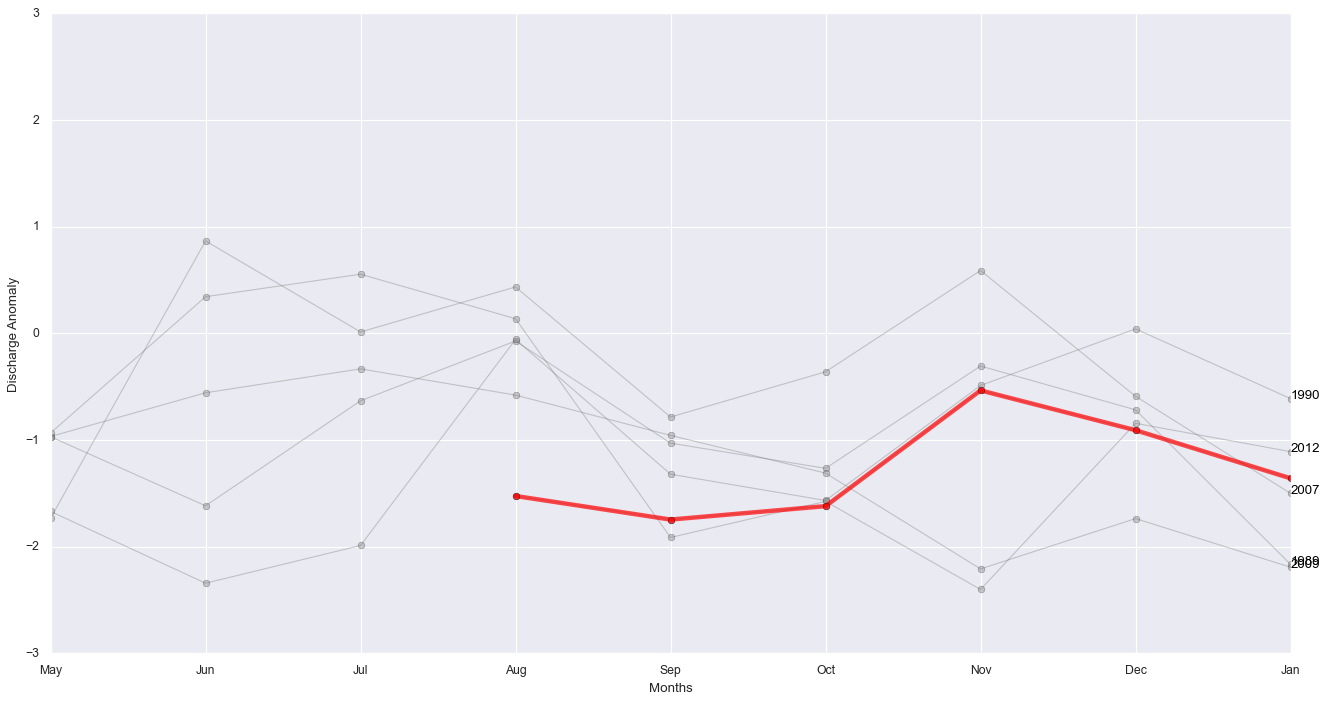

In [65]:
plt.figure(figsize=(20, 10))

# plot multiple lines
for column in ANOMALY_PLOT.drop('MONTH', axis=1):
    plt.plot(ANOMALY_PLOT['MONTH'], ANOMALY_PLOT[column], marker='o', color='grey', linewidth=1, alpha=0.4);

# Now re do the interesting curve, but biger with distinct color
plt.plot(ANOMALY_PLOT['MONTH'], ANOMALY_PLOT['REF'], marker='o', color='red', linewidth=4, alpha=0.7);

num=0
for i in ANOMALY_PLOT.values[8][1:]:
    num+=1
    name=list(ANOMALY_PLOT)[num]
    if name != 'REF':
        plt.text(8, i, name, horizontalalignment='left', size='medium', color='black')
        
plt.ylim(-3,3)
plt.xlabel('Months');
plt.ylabel('Discharge Anomaly');



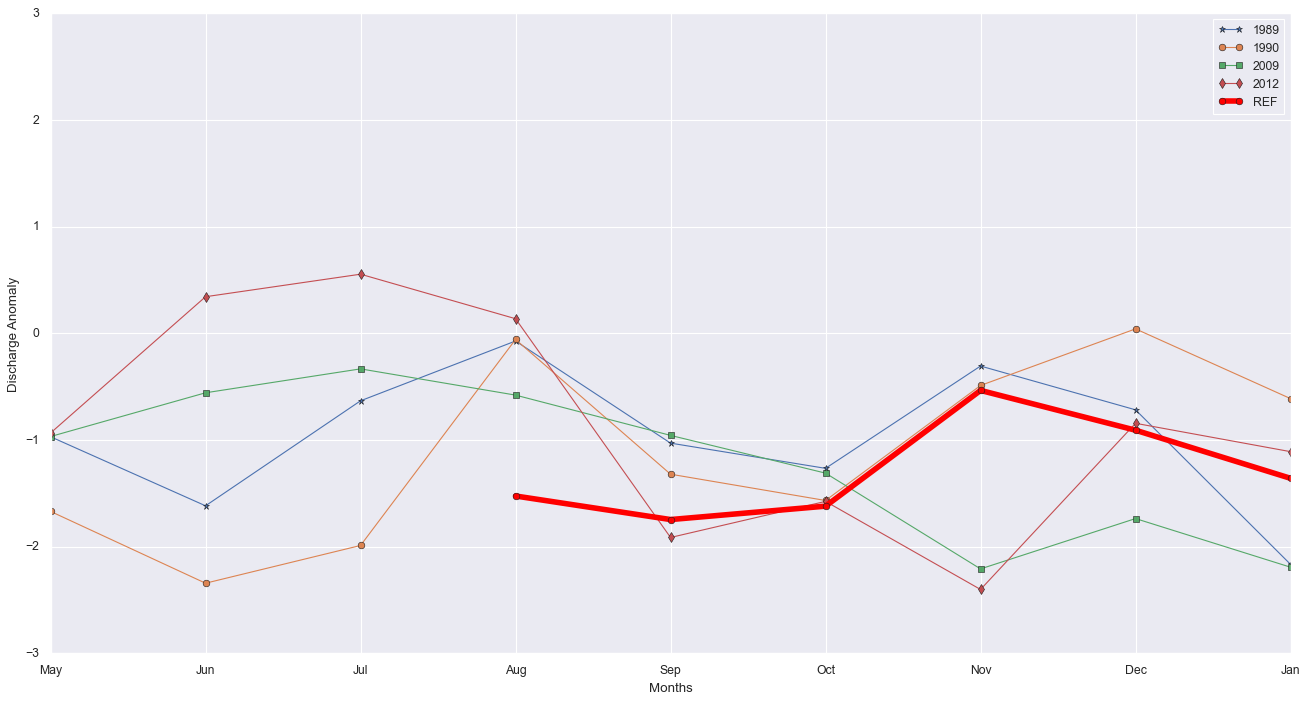

In [66]:
plt.figure(figsize=(20, 10))

# plot multiple lines
for column, m in zip(ANOMALY_PLOT.drop('MONTH', axis=1), '*osd'):
    plt.plot(ANOMALY_PLOT['MONTH'], ANOMALY_PLOT[column], marker=m, linewidth=1, alpha=1, label=column);

# Now re do the interesting curve, but biger with distinct color
plt.plot(ANOMALY_PLOT['MONTH'], ANOMALY_PLOT['REF'], marker='o', color='red', linewidth=5, alpha=1, label=list(ANOMALY_PLOT)[-1]);


plt.legend(loc='best')
plt.ylim(-3,3)
plt.xlabel('Months');
plt.ylabel('Discharge Anomaly');

## Calculation of weight 

In [67]:
w = (1/BEST_RMSE['RMSE'].values) / (1/BEST_RMSE['RMSE'].values).sum()

In [68]:
w

array([0.24108167, 0.23102147, 0.18712337, 0.17884836, 0.16192512])

# Most similars analogue years

Print the similar analogues year

In [69]:
for i in range(0,len(ANOMALY_PLOT.columns[1:-1])):
    print(f'{i+1}° similar analogues year is:',str(BEST_RMSE['YEAR'].iloc[i]))

1° similar analogues year is: 1989
2° similar analogues year is: 1990
3° similar analogues year is: 2009
4° similar analogues year is: 2012
5° similar analogues year is: 2007


In [70]:
ONE_MONTH = add_months(END_DATE_HIST,1)

In [71]:
year_lst = []
for i in range(len(BEST_RMSE['YEAR'])):
    year_lst.append(BEST_RMSE['YEAR'].iloc[i])

In [72]:
dic = {'MONTH' : [calendar.month_abbr[ONE_MONTH.month]]*5,
       'YEAR': year_lst}

In [73]:
ANALOGUE_FORECAST = pd.DataFrame(dic)
ANALOGUE_FORECAST.set_index('MONTH',inplace=True)

In [74]:
ANALOGUE_FORECAST

,YEAR
MONTH,
Feb,1989
Feb,1990
Feb,2009
Feb,2012
Feb,2007


In [75]:
ANOMALY_ANALOGUE_TS

,Month,Year,Anomaly_Qlog,DATE
0,1,1980,0.246433,1980-01-01
1,2,1980,0.273627,1980-02-01
2,3,1980,0.865486,1980-03-01
3,4,1980,1.233892,1980-04-01
4,5,1980,0.823457,1980-05-01
...,...,...,...,...
523,8,2023,NaN,2023-08-01
524,9,2023,NaN,2023-09-01
525,10,2023,NaN,2023-10-01
526,11,2023,NaN,2023-11-01


In [76]:
aux = []
value_m = ONE_MONTH.month 
for i in range(0,len(ANOMALY_PLOT.columns[1:-1])):
    value_y = BEST_RMSE['YEAR'].iloc[i]
    aux.append(ANOMALY_ANALOGUE_TS.query('Month == @value_m & Year == @value_y').Anomaly_Qlog.values[0])

In [77]:
aux

[-2.2714046826012337,
 -0.041997098462068706,
 -0.8823674133057612,
 -1.2282738371806365,
 -1.6689321133399555]

In [78]:
ANALOGUE_FORECAST['Anomaly_Qlog']=np.array(aux)

In [79]:
ANALOGUE_FORECAST

,YEAR,Anomaly_Qlog
MONTH,,
Feb,1989,-2.271405
Feb,1990,-0.041997
Feb,2009,-0.882367
Feb,2012,-1.228274
Feb,2007,-1.668932


In [80]:
ANALOGUE_FORECAST['Weight'] = w

In [81]:
ANALOGUE_FORECAST

,YEAR,Anomaly_Qlog,Weight
MONTH,,,
Feb,1989,-2.271405,0.241082
Feb,1990,-0.041997,0.231021
Feb,2009,-0.882367,0.187123
Feb,2012,-1.228274,0.178848
Feb,2007,-1.668932,0.161925


In [82]:
ANALOGUE_FORECAST_1_monthFcst = (ANALOGUE_FORECAST['Weight'] * ANALOGUE_FORECAST['Anomaly_Qlog']).sum()

In [83]:
ANALOGUE_FORECAST_1_monthFcst

-1.2123246382667645

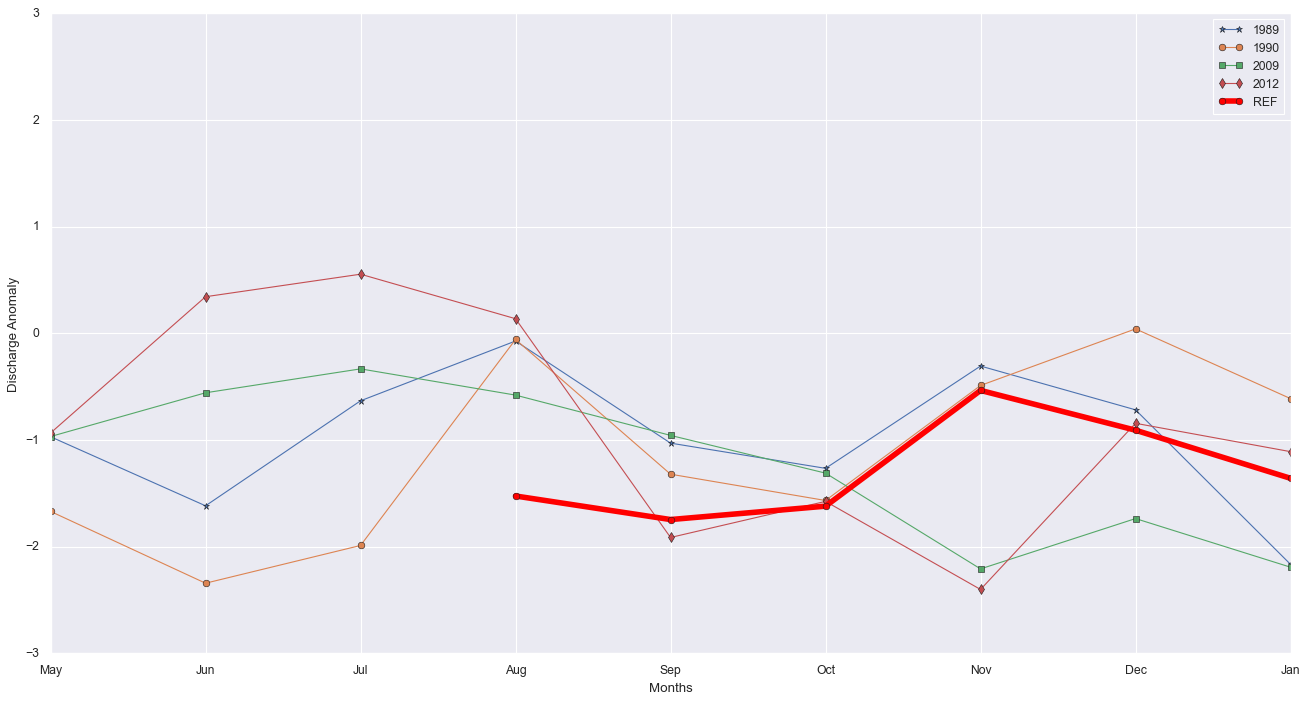

In [84]:
plt.figure(figsize=(20, 10))

# plot multiple lines
for column, m in zip(ANOMALY_PLOT.drop('MONTH', axis=1), '*osd'):
    plt.plot(ANOMALY_PLOT['MONTH'], ANOMALY_PLOT[column], marker=m, linewidth=1, alpha=1, label=column);

# Now re do the interesting curve, but biger with distinct color
plt.plot(ANOMALY_PLOT['MONTH'], ANOMALY_PLOT['REF'], marker='o', color='red', linewidth=5, alpha=1, label=list(ANOMALY_PLOT)[-1]);


plt.legend(loc='best')
plt.ylim(-3,3)
plt.xlabel('Months');
plt.ylabel('Discharge Anomaly');

In [85]:
ANOMALY_PLOT_FORECAST = ANOMALY_PLOT

In [86]:
ANOMALY_PLOT_FORECAST

,MONTH,1989,1990,2009,2012,2007,REF
0,May,-0.969359,-1.669311,-0.967503,-0.934576,-1.733629,NaN
1,Jun,-1.616891,-2.342581,-0.557374,0.343248,0.866158,NaN
2,Jul,-0.632508,-1.988811,-0.333168,0.554437,0.012973,NaN
3,Aug,-0.071836,-0.057456,-0.579201,0.137058,0.434897,-1.524998
4,Sep,-1.029305,-1.320600,-0.956767,-1.913879,-0.784589,-1.745873
5,Oct,-1.265752,-1.567117,-1.310581,-1.575410,-0.360460,-1.620122
6,Nov,-0.306612,-0.488682,-2.208465,-2.401258,0.589034,-0.535129
7,Dec,-0.717159,0.041827,-1.736584,-0.843398,-0.590456,-0.908354
8,Jan,-2.165909,-0.611929,-2.192448,-1.109293,-1.500133,-1.359237


In [87]:
to_add = ANALOGUE_FORECAST['Anomaly_Qlog'].values.tolist()

to_add.insert(0,calendar.month_abbr[ONE_MONTH.month])

to_add.insert(len(ANALOGUE_FORECAST.index)+1,ANALOGUE_FORECAST_1_monthFcst)


In [88]:
to_add

['Feb',
 -2.2714046826012337,
 -0.041997098462068706,
 -0.8823674133057612,
 -1.2282738371806365,
 -1.6689321133399555,
 -1.2123246382667645]

In [89]:
ANOMALY_PLOT_FORECAST.loc[len(ANOMALY_PLOT_FORECAST.index)] = to_add

In [90]:
ANOMALY_PLOT_FORECAST

,MONTH,1989,1990,2009,2012,2007,REF
0,May,-0.969359,-1.669311,-0.967503,-0.934576,-1.733629,NaN
1,Jun,-1.616891,-2.342581,-0.557374,0.343248,0.866158,NaN
2,Jul,-0.632508,-1.988811,-0.333168,0.554437,0.012973,NaN
3,Aug,-0.071836,-0.057456,-0.579201,0.137058,0.434897,-1.524998
4,Sep,-1.029305,-1.320600,-0.956767,-1.913879,-0.784589,-1.745873
5,Oct,-1.265752,-1.567117,-1.310581,-1.575410,-0.360460,-1.620122
6,Nov,-0.306612,-0.488682,-2.208465,-2.401258,0.589034,-0.535129
7,Dec,-0.717159,0.041827,-1.736584,-0.843398,-0.590456,-0.908354
8,Jan,-2.165909,-0.611929,-2.192448,-1.109293,-1.500133,-1.359237
9,Feb,-2.271405,-0.041997,-0.882367,-1.228274,-1.668932,-1.212325


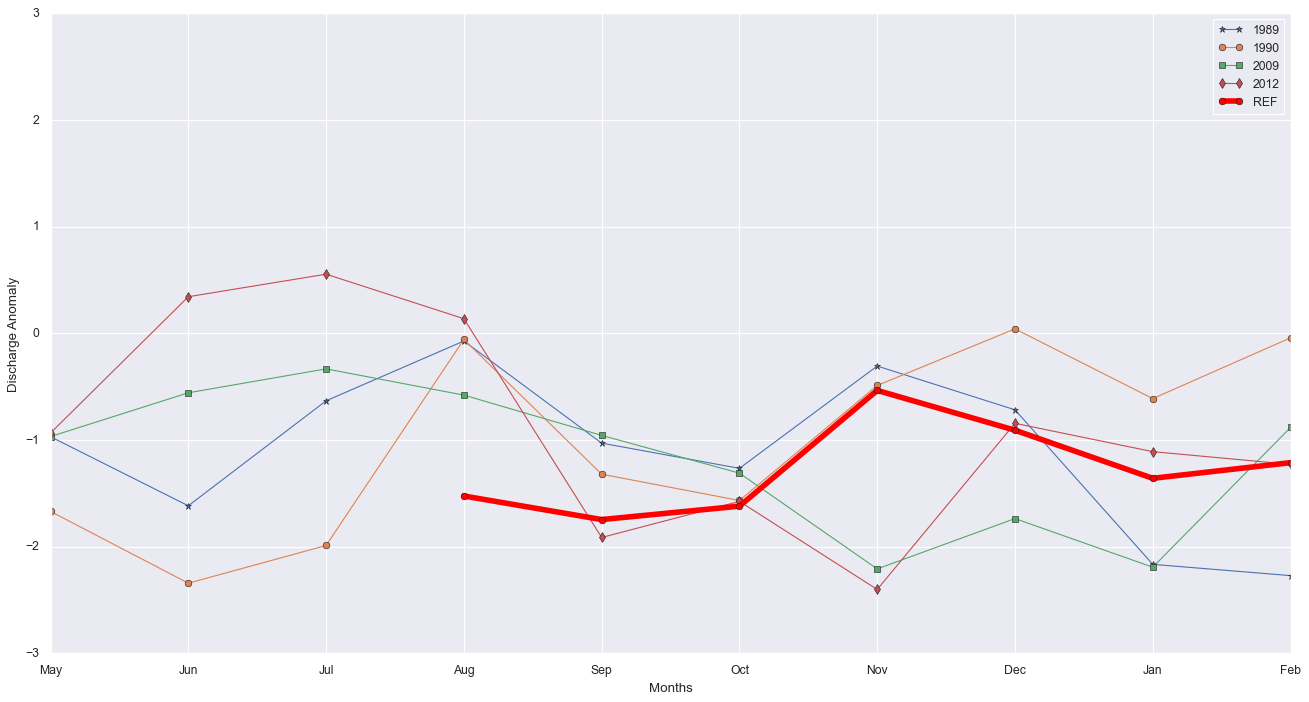

In [91]:
plt.figure(figsize=(20, 10))

# plot multiple lines
for column, m in zip(ANOMALY_PLOT_FORECAST.drop('MONTH', axis=1), '*osd'):
    plt.plot(ANOMALY_PLOT_FORECAST['MONTH'], ANOMALY_PLOT_FORECAST[column], marker=m, linewidth=1, alpha=1, label=column);

# Now re do the interesting curve, but biger with distinct color
plt.plot(ANOMALY_PLOT_FORECAST['MONTH'], ANOMALY_PLOT_FORECAST['REF'], marker='o', color='red', linewidth=5, alpha=1, label=list(ANOMALY_PLOT_FORECAST)[-1]);


plt.legend(loc='best')
plt.ylim(-3,3)
plt.xlabel('Months');
plt.ylabel('Discharge Anomaly');

Copy variable for Excel

In [92]:
ANOMALY_PLOT.to_clipboard()

In [93]:
ANOMALY_ANALOGUE_TS.to_clipboard()